## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 63.1MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## Optunaによるハイパーパラメーターチューニング

In [ ]:
!pip install optuna
!pip install category_encoders
!pip install pandas

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 44.5 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 59.7 MB/s 
     |████████████████████████████████| 149 kB 36.3 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=60b8ec4dcb828a3d84284e4140ddd75d46f14c4f050aa954725d29777d266327
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 82 kB 357 kB/s 


In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


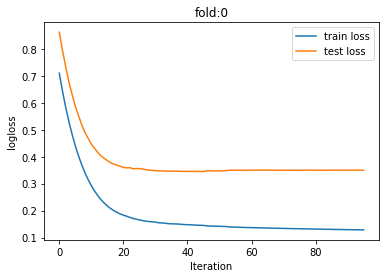

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997


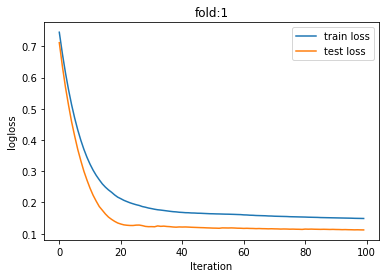

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503


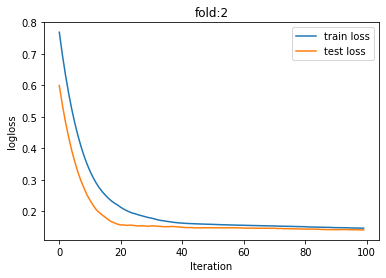

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725


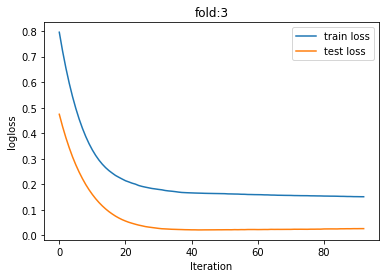

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033


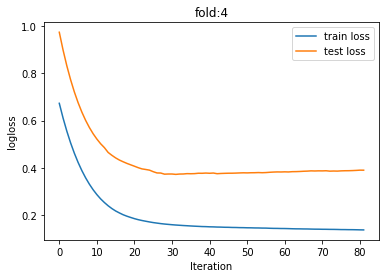

RMSE: [0.3450743092184951, 0.1119966357028154, 0.141502625741997, 0.021772539884382606, 0.37303280298429786]
RMSE: 0.1986757827063976


In [ ]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},           # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

### optuna.integration.lightgbm によるハイパーパラメーター調整実施



[I 2021-12-12 02:43:59,433] A new study created in memory with name: no-name-b9fe2414-c26e-4127-810d-06d887f942cd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  14%|#4        | 1/7 [00:00<00:02,  2.15it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.142844	Test's rmse: 0.345643
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  29%|##8       | 2/7 [00:00<00:02,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121108	Test's rmse: 0.35739
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  43%|####2     | 3/7 [00:01<00:01,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116552	Test's rmse: 0.357411
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  57%|#####7    | 4/7 [00:01<00:01,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108445	Test's rmse: 0.340763
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  71%|#######1  | 5/7 [00:02<00:00,  2.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108089	Test's rmse: 0.364121
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  86%|########5 | 6/7 [00:02<00:00,  2.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104324	Test's rmse: 0.352257
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763: 100%|##########| 7/7 [00:03<00:00,  2.27it/s]


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


num_leaves, val_score: 0.340763:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:   5%|5         | 1/20 [00:00<00:17,  1.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109824	Test's rmse: 0.344876
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  10%|#         | 2/20 [00:02<00:25,  1.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111376	Test's rmse: 0.348737


num_leaves, val_score: 0.340763:  15%|#5        | 3/20 [00:02<00:15,  1.10it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121768	Test's rmse: 0.343894


[I 2021-12-12 02:44:05,535] Trial 9 finished with value: 0.3438937342933316 and parameters: {'num_leaves': 10}. Best is trial 9 with value: 0.3438937342933316.
num_leaves, val_score: 0.340763:  15%|#5        | 3/20 [00:03<00:15,  1.10it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111744	Test's rmse: 0.347635
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  25%|##5       | 5/20 [00:04<00:13,  1.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108445	Test's rmse: 0.340763
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  30%|###       | 6/20 [00:06<00:13,  1.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113673	Test's rmse: 0.347246
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  35%|###5      | 7/20 [00:07<00:15,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112893	Test's rmse: 0.34501
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  40%|####      | 8/20 [00:09<00:15,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111744	Test's rmse: 0.347635
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  45%|####5     | 9/20 [00:10<00:15,  1.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113853	Test's rmse: 0.347245
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  50%|#####     | 10/20 [00:12<00:14,  1.49s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113671	Test's rmse: 0.348754


num_leaves, val_score: 0.328947:  55%|#####5    | 11/20 [00:12<00:09,  1.08s/it]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183369	Test's rmse: 0.328947
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  60%|######    | 12/20 [00:12<00:06,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183369	Test's rmse: 0.328947
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  70%|#######   | 14/20 [00:13<00:03,  1.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109634	Test's rmse: 0.344611
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183369	Test's rmse: 0.328947
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  75%|#######5  | 15/20 [00:14<00:03,  1.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.10679	Test's rmse: 0.343684
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  80%|########  | 16/20 [00:14<00:02,  1.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110652	Test's rmse: 0.341312
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  85%|########5 | 17/20 [00:15<00:02,  1.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112236	Test's rmse: 0.347518
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  90%|######### | 18/20 [00:17<00:01,  1.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112286	Test's rmse: 0.346965
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947:  95%|#########5| 19/20 [00:17<00:00,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110435	Test's rmse: 0.338156
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.328947: 100%|##########| 20/20 [00:18<00:00,  1.09it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104423	Test's rmse: 0.344644


bagging, val_score: 0.328947:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328947:  10%|#         | 1/10 [00:00<00:01,  5.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183272	Test's rmse: 0.328985
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328947:  20%|##        | 2/10 [00:00<00:01,  5.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183294	Test's rmse: 0.329028


bagging, val_score: 0.328947:  30%|###       | 3/10 [00:00<00:01,  6.13it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183279	Test's rmse: 0.32956
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328763:  40%|####      | 4/10 [00:00<00:00,  6.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182833	Test's rmse: 0.328763
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328757:  50%|#####     | 5/10 [00:00<00:00,  5.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183217	Test's rmse: 0.328757


bagging, val_score: 0.328757:  60%|######    | 6/10 [00:01<00:00,  6.14it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183121	Test's rmse: 0.329783
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328757:  70%|#######   | 7/10 [00:01<00:00,  6.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185193	Test's rmse: 0.328769
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328757:  80%|########  | 8/10 [00:01<00:00,  6.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183665	Test's rmse: 0.329487


bagging, val_score: 0.328757:  90%|######### | 9/10 [00:01<00:00,  6.09it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183049	Test's rmse: 0.328824
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328550: 100%|##########| 10/10 [00:01<00:00,  5.97it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182678	Test's rmse: 0.32855


feature_fraction_stage2, val_score: 0.328550:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328461:  17%|#6        | 1/6 [00:00<00:00,  5.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328461:  33%|###3      | 2/6 [00:00<00:00,  5.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.185309	Test's rmse: 0.329851


feature_fraction_stage2, val_score: 0.328461:  50%|#####     | 3/6 [00:00<00:00,  6.00it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183463	Test's rmse: 0.329227
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328461:  67%|######6   | 4/6 [00:00<00:00,  5.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182678	Test's rmse: 0.32855
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328461:  83%|########3 | 5/6 [00:00<00:00,  5.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182678	Test's rmse: 0.32855


feature_fraction_stage2, val_score: 0.328461:  83%|########3 | 5/6 [00:01<00:00,  5.83it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183463	Test's rmse: 0.329227


regularization_factors, val_score: 0.328461:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:   5%|5         | 1/20 [00:00<00:03,  5.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  10%|#         | 2/20 [00:00<00:03,  5.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461


regularization_factors, val_score: 0.328461:  15%|#5        | 3/20 [00:00<00:02,  5.68it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  20%|##        | 4/20 [00:00<00:02,  5.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182334	Test's rmse: 0.328618
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  25%|##5       | 5/20 [00:00<00:02,  5.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461


regularization_factors, val_score: 0.328461:  30%|###       | 6/20 [00:01<00:02,  5.65it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182628	Test's rmse: 0.329493
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  35%|###5      | 7/20 [00:01<00:02,  5.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182288	Test's rmse: 0.328466
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  40%|####      | 8/20 [00:01<00:02,  5.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461


regularization_factors, val_score: 0.328461:  45%|####5     | 9/20 [00:01<00:01,  5.56it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182738	Test's rmse: 0.328943
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328461:  50%|#####     | 10/20 [00:01<00:01,  5.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  55%|#####5    | 11/20 [00:01<00:01,  5.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182233	Test's rmse: 0.328362


[I 2021-12-12 02:44:25,641] Trial 53 finished with value: 0.32836225425372106 and parameters: {'lambda_l1': 2.8155870429723693e-06, 'lambda_l2': 0.0893827882237657}. Best is trial 53 with value: 0.32836225425372106.
regularization_factors, val_score: 0.328362:  55%|#####5    | 11/20 [00:02<00:01,  5.49it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182235	Test's rmse: 0.328362


regularization_factors, val_score: 0.328362:  60%|######    | 12/20 [00:02<00:01,  5.38it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  65%|######5   | 13/20 [00:02<00:01,  5.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182242	Test's rmse: 0.328375
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  70%|#######   | 14/20 [00:02<00:01,  5.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182233	Test's rmse: 0.328362


regularization_factors, val_score: 0.328362:  75%|#######5  | 15/20 [00:02<00:00,  5.53it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182681	Test's rmse: 0.329033
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  80%|########  | 16/20 [00:02<00:00,  5.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182232	Test's rmse: 0.328363
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  85%|########5 | 17/20 [00:03<00:00,  5.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182308	Test's rmse: 0.328497


regularization_factors, val_score: 0.328362:  90%|######### | 18/20 [00:03<00:00,  5.40it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182231	Test's rmse: 0.328363


[I 2021-12-12 02:44:26,939] Trial 60 finished with value: 0.32836322065584944 and parameters: {'lambda_l1': 8.328840177163545e-07, 'lambda_l2': 0.02466559985362528}. Best is trial 54 with value: 0.32836164025907494.
regularization_factors, val_score: 0.328362:  90%|######### | 18/20 [00:03<00:00,  5.40it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362:  95%|#########5| 19/20 [00:03<00:00,  5.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182286	Test's rmse: 0.328461
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328362: 100%|##########| 20/20 [00:03<00:00,  5.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182327	Test's rmse: 0.328626


[I 2021-12-12 02:44:27,311] Trial 62 finished with value: 0.3286256642782288 and parameters: {'lambda_l1': 0.0013772688953234476, 'lambda_l2': 0.9213013326961217}. Best is trial 54 with value: 0.32836164025907494.
min_data_in_leaf, val_score: 0.328362:  20%|##        | 1/5 [00:00<00:00,  6.17it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182053	Test's rmse: 0.329219


[I 2021-12-12 02:44:27,493] Trial 63 finished with value: 0.32921909395633936 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.32921909395633936.
min_data_in_leaf, val_score: 0.328362:  20%|##        | 1/5 [00:00<00:00,  6.17it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328362:  40%|####      | 2/5 [00:00<00:00,  5.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182053	Test's rmse: 0.329219
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328362:  80%|########  | 4/5 [00:00<00:00,  5.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182511	Test's rmse: 0.329351
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.245037	Test's rmse: 0.378835


min_data_in_leaf, val_score: 0.328362: 100%|##########| 5/5 [00:00<00:00,  5.66it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.280304	Test's rmse: 0.414407


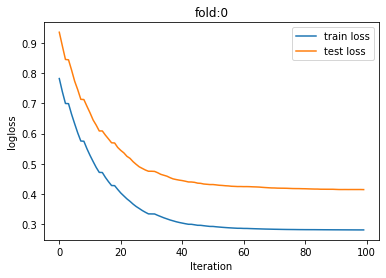

[I 2021-12-12 02:44:28,426] A new study created in memory with name: no-name-4ddc5fef-114d-4076-8f8e-4320cdb67665
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  14%|#4        | 1/7 [00:00<00:02,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131381	Test's rmse: 0.107196
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  29%|##8       | 2/7 [00:00<00:02,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133052	Test's rmse: 0.136101
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  43%|####2     | 3/7 [00:01<00:01,  2.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  57%|#####7    | 4/7 [00:01<00:01,  2.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146464	Test's rmse: 0.11008
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  71%|#######1  | 5/7 [00:02<00:00,  2.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140926	Test's rmse: 0.139514
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  86%|########5 | 6/7 [00:02<00:00,  2.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128728	Test's rmse: 0.109712
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196: 100%|##########| 7/7 [00:03<00:00,  2.28it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131213	Test's rmse: 0.124715


num_leaves, val_score: 0.107196:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:   5%|5         | 1/20 [00:00<00:16,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13535	Test's rmse: 0.110357
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  10%|#         | 2/20 [00:02<00:24,  1.37s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137463	Test's rmse: 0.116215
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  15%|#5        | 3/20 [00:04<00:24,  1.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129382	Test's rmse: 0.112883
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  20%|##        | 4/20 [00:05<00:23,  1.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132664	Test's rmse: 0.111259
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  25%|##5       | 5/20 [00:07<00:22,  1.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134159	Test's rmse: 0.115726
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  30%|###       | 6/20 [00:08<00:19,  1.38s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131767	Test's rmse: 0.11361
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  35%|###5      | 7/20 [00:09<00:18,  1.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13488	Test's rmse: 0.115053
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  40%|####      | 8/20 [00:10<00:14,  1.25s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131032	Test's rmse: 0.11151
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106743:  45%|####5     | 9/20 [00:11<00:11,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131326	Test's rmse: 0.106743
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106743:  50%|#####     | 10/20 [00:12<00:10,  1.06s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138359	Test's rmse: 0.115759
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.103469:  55%|#####5    | 11/20 [00:12<00:07,  1.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132837	Test's rmse: 0.103469
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  60%|######    | 12/20 [00:13<00:05,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  70%|#######   | 14/20 [00:13<00:02,  2.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162988	Test's rmse: 0.112545
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199375	Test's rmse: 0.119861


[I 2021-12-12 02:44:45,032] Trial 20 finished with value: 0.1198610325151871 and parameters: {'num_leaves': 3}. Best is trial 18 with value: 0.10057772456165265.
num_leaves, val_score: 0.100578:  70%|#######   | 14/20 [00:13<00:02,  2.27it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  75%|#######5  | 15/20 [00:14<00:02,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129319	Test's rmse: 0.107894
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  80%|########  | 16/20 [00:14<00:02,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130904	Test's rmse: 0.10736
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  85%|########5 | 17/20 [00:15<00:01,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131103	Test's rmse: 0.111943
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  90%|######### | 18/20 [00:16<00:01,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132426	Test's rmse: 0.11263
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578:  95%|#########5| 19/20 [00:16<00:00,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132442	Test's rmse: 0.101572
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.100578: 100%|##########| 20/20 [00:17<00:00,  1.14it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131141	Test's rmse: 0.111226


bagging, val_score: 0.100578:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  10%|#         | 1/10 [00:00<00:03,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180824	Test's rmse: 0.119637
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  20%|##        | 2/10 [00:00<00:03,  2.64it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.166585	Test's rmse: 0.117438
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  30%|###       | 3/10 [00:01<00:02,  2.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144969	Test's rmse: 0.110653
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  40%|####      | 4/10 [00:01<00:02,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144683	Test's rmse: 0.111924
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  50%|#####     | 5/10 [00:01<00:01,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130993	Test's rmse: 0.101153
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  60%|######    | 6/10 [00:02<00:01,  2.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164271	Test's rmse: 0.111171
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  70%|#######   | 7/10 [00:02<00:01,  2.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179325	Test's rmse: 0.117062
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  80%|########  | 8/10 [00:03<00:00,  2.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181077	Test's rmse: 0.118623
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578:  90%|######### | 9/10 [00:03<00:00,  2.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170054	Test's rmse: 0.1262
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.100578: 100%|##########| 10/10 [00:03<00:00,  2.54it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133063	Test's rmse: 0.104348


feature_fraction_stage2, val_score: 0.100578:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578:  17%|#6        | 1/6 [00:00<00:01,  2.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129347	Test's rmse: 0.107022
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578:  33%|###3      | 2/6 [00:00<00:01,  2.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127834	Test's rmse: 0.10802
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578:  50%|#####     | 3/6 [00:01<00:01,  2.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130775	Test's rmse: 0.102374
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578:  67%|######6   | 4/6 [00:01<00:00,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578:  83%|########3 | 5/6 [00:01<00:00,  2.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.100578: 100%|##########| 6/6 [00:02<00:00,  2.81it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127834	Test's rmse: 0.10802


regularization_factors, val_score: 0.100578:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:   5%|5         | 1/20 [00:00<00:06,  2.74it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131551	Test's rmse: 0.103727
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  10%|#         | 2/20 [00:00<00:06,  2.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135842	Test's rmse: 0.106301
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  15%|#5        | 3/20 [00:01<00:05,  2.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142564	Test's rmse: 0.112244
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  20%|##        | 4/20 [00:01<00:05,  2.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136035	Test's rmse: 0.105722
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  25%|##5       | 5/20 [00:01<00:05,  2.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134324	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  30%|###       | 6/20 [00:02<00:04,  2.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134503	Test's rmse: 0.110472
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  35%|###5      | 7/20 [00:02<00:04,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134323	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  40%|####      | 8/20 [00:02<00:04,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  45%|####5     | 9/20 [00:03<00:03,  2.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134325	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  50%|#####     | 10/20 [00:03<00:03,  2.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134947	Test's rmse: 0.101468
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  55%|#####5    | 11/20 [00:03<00:03,  2.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134323	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  60%|######    | 12/20 [00:04<00:02,  2.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  65%|######5   | 13/20 [00:04<00:02,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  70%|#######   | 14/20 [00:04<00:02,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136016	Test's rmse: 0.102253
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  75%|#######5  | 15/20 [00:05<00:01,  2.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  80%|########  | 16/20 [00:05<00:01,  2.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  85%|########5 | 17/20 [00:05<00:01,  2.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  90%|######### | 18/20 [00:06<00:00,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578:  95%|#########5| 19/20 [00:06<00:00,  2.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.100578: 100%|##########| 20/20 [00:07<00:00,  2.81it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134322	Test's rmse: 0.100578


min_data_in_leaf, val_score: 0.100578:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.092042:  20%|##        | 1/5 [00:00<00:01,  3.06it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.126122	Test's rmse: 0.0920417
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.092042:  40%|####      | 2/5 [00:00<00:01,  2.74it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.240819	Test's rmse: 0.186745
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.092042:  60%|######    | 3/5 [00:01<00:00,  2.88it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.071446	Test's rmse: 0.131029
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.092042:  80%|########  | 4/5 [00:01<00:00,  2.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154752	Test's rmse: 0.113504
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.092042: 100%|##########| 5/5 [00:01<00:00,  2.89it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.337578	Test's rmse: 0.228587


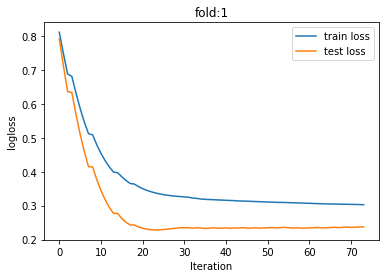

[I 2021-12-12 02:45:04,300] A new study created in memory with name: no-name-a4cad350-69bc-469f-95ae-198f8c810b71
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.174646:  14%|#4        | 1/7 [00:00<00:02,  2.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140306	Test's rmse: 0.174646
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.142317:  29%|##8       | 2/7 [00:00<00:02,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  43%|####2     | 3/7 [00:01<00:01,  2.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  57%|#####7    | 4/7 [00:01<00:01,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141856	Test's rmse: 0.139473
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  71%|#######1  | 5/7 [00:02<00:00,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130492	Test's rmse: 0.161674
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  86%|########5 | 6/7 [00:02<00:00,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256: 100%|##########| 7/7 [00:03<00:00,  2.22it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123915	Test's rmse: 0.144274


num_leaves, val_score: 0.139256:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:   5%|5         | 1/20 [00:01<00:24,  1.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13594	Test's rmse: 0.145173
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  10%|#         | 2/20 [00:03<00:27,  1.54s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134677	Test's rmse: 0.148526
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  15%|#5        | 3/20 [00:04<00:23,  1.40s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136029	Test's rmse: 0.148033
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  20%|##        | 4/20 [00:05<00:21,  1.37s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136445	Test's rmse: 0.145214
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  25%|##5       | 5/20 [00:06<00:17,  1.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140979	Test's rmse: 0.144671
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  30%|###       | 6/20 [00:06<00:13,  1.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131055	Test's rmse: 0.139887
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  35%|###5      | 7/20 [00:07<00:11,  1.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131985	Test's rmse: 0.14344
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  40%|####      | 8/20 [00:07<00:07,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176276	Test's rmse: 0.155304
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  45%|####5     | 9/20 [00:09<00:09,  1.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134563	Test's rmse: 0.145922
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  50%|#####     | 10/20 [00:10<00:09,  1.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139476	Test's rmse: 0.146792
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  55%|#####5    | 11/20 [00:10<00:07,  1.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  60%|######    | 12/20 [00:11<00:05,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133789	Test's rmse: 0.141292
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  65%|######5   | 13/20 [00:11<00:04,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134337	Test's rmse: 0.140622
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  70%|#######   | 14/20 [00:12<00:03,  1.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139068	Test's rmse: 0.14407
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  75%|#######5  | 15/20 [00:13<00:03,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124657	Test's rmse: 0.141484
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  80%|########  | 16/20 [00:13<00:02,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12953	Test's rmse: 0.139404
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  85%|########5 | 17/20 [00:14<00:02,  1.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13461	Test's rmse: 0.144988
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  90%|######### | 18/20 [00:16<00:02,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133618	Test's rmse: 0.146415
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130:  95%|#########5| 19/20 [00:17<00:00,  1.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132758	Test's rmse: 0.143355
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.138130: 100%|##########| 20/20 [00:18<00:00,  1.10it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138591	Test's rmse: 0.145014


bagging, val_score: 0.138130:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  10%|#         | 1/10 [00:00<00:04,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142664	Test's rmse: 0.144954
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  20%|##        | 2/10 [00:00<00:03,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138824	Test's rmse: 0.146864
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  30%|###       | 3/10 [00:01<00:03,  2.15it/s]

Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.164577	Test's rmse: 0.155607
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  40%|####      | 4/10 [00:01<00:02,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135829	Test's rmse: 0.143583
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  50%|#####     | 5/10 [00:02<00:02,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132462	Test's rmse: 0.145467
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  60%|######    | 6/10 [00:02<00:01,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151906	Test's rmse: 0.155331
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  70%|#######   | 7/10 [00:03<00:01,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158163	Test's rmse: 0.150917
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  80%|########  | 8/10 [00:03<00:00,  2.16it/s]

Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.177937	Test's rmse: 0.159935
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130:  90%|######### | 9/10 [00:04<00:00,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153117	Test's rmse: 0.156633
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.138130: 100%|##########| 10/10 [00:04<00:00,  2.14it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136831	Test's rmse: 0.144631


feature_fraction_stage2, val_score: 0.138130:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130:  17%|#6        | 1/6 [00:00<00:02,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130:  33%|###3      | 2/6 [00:00<00:01,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122274	Test's rmse: 0.145629
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130:  50%|#####     | 3/6 [00:01<00:01,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141972	Test's rmse: 0.141308
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130:  67%|######6   | 4/6 [00:01<00:00,  2.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141972	Test's rmse: 0.141308
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130:  83%|########3 | 5/6 [00:02<00:00,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132598	Test's rmse: 0.141886
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138130: 100%|##########| 6/6 [00:02<00:00,  2.42it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132598	Test's rmse: 0.141886


regularization_factors, val_score: 0.138130:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:   5%|5         | 1/20 [00:00<00:07,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125002	Test's rmse: 0.148953
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  10%|#         | 2/20 [00:00<00:07,  2.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130982	Test's rmse: 0.149101
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  15%|#5        | 3/20 [00:01<00:06,  2.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128508	Test's rmse: 0.144298
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  20%|##        | 4/20 [00:01<00:06,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  25%|##5       | 5/20 [00:01<00:06,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  30%|###       | 6/20 [00:02<00:05,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128084	Test's rmse: 0.141582
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  35%|###5      | 7/20 [00:02<00:05,  2.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129792	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  40%|####      | 8/20 [00:03<00:04,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129793	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  45%|####5     | 9/20 [00:03<00:04,  2.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14049	Test's rmse: 0.150903
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  50%|#####     | 10/20 [00:04<00:04,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  55%|#####5    | 11/20 [00:04<00:03,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  60%|######    | 12/20 [00:04<00:03,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  65%|######5   | 13/20 [00:05<00:02,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  70%|#######   | 14/20 [00:05<00:02,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13099	Test's rmse: 0.14209
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  75%|#######5  | 15/20 [00:06<00:02,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  80%|########  | 16/20 [00:06<00:01,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135153	Test's rmse: 0.138834
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  85%|########5 | 17/20 [00:06<00:01,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  90%|######### | 18/20 [00:07<00:00,  2.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131324	Test's rmse: 0.139073
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130:  95%|#########5| 19/20 [00:07<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138130: 100%|##########| 20/20 [00:08<00:00,  2.44it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.13813


min_data_in_leaf, val_score: 0.138130:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138130:  20%|##        | 1/5 [00:00<00:01,  2.53it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0688108	Test's rmse: 0.149007
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138130:  40%|####      | 2/5 [00:00<00:01,  2.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0707732	Test's rmse: 0.151813
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138130:  60%|######    | 3/5 [00:01<00:00,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.281813	Test's rmse: 0.19696
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138130:  80%|########  | 4/5 [00:01<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145796	Test's rmse: 0.151761
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138130: 100%|##########| 5/5 [00:02<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.228578	Test's rmse: 0.175699


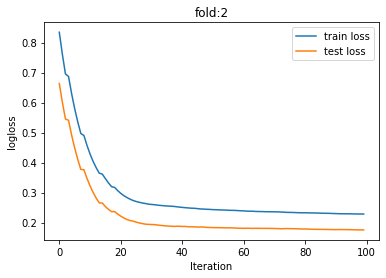

[I 2021-12-12 02:45:43,281] A new study created in memory with name: no-name-72bf0dfd-5444-4378-9451-9661bd475ef4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.106158:  14%|#4        | 1/7 [00:00<00:02,  2.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142166	Test's rmse: 0.106158
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.083282:  29%|##8       | 2/7 [00:00<00:02,  2.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13123	Test's rmse: 0.0832825
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.083282:  43%|####2     | 3/7 [00:01<00:01,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137443	Test's rmse: 0.100619
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  57%|#####7    | 4/7 [00:01<00:01,  2.27it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  71%|#######1  | 5/7 [00:02<00:00,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12607	Test's rmse: 0.0474248
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  86%|########5 | 6/7 [00:02<00:00,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153403	Test's rmse: 0.0395883
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773: 100%|##########| 7/7 [00:03<00:00,  2.25it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132491	Test's rmse: 0.0663863


num_leaves, val_score: 0.021773:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021773:   5%|5         | 1/20 [00:01<00:32,  1.70s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221606
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021773:  10%|#         | 2/20 [00:03<00:28,  1.59s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165287	Test's rmse: 0.0220714
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021644:  15%|#5        | 3/20 [00:03<00:19,  1.14s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164229	Test's rmse: 0.0216442
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021644:  20%|##        | 4/20 [00:04<00:14,  1.12it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.166609	Test's rmse: 0.0218514
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021644:  25%|##5       | 5/20 [00:05<00:17,  1.15s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221473
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021353:  30%|###       | 6/20 [00:06<00:11,  1.17it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021353:  35%|###5      | 7/20 [00:07<00:14,  1.14s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221596
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021353:  40%|####      | 8/20 [00:09<00:15,  1.29s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221615
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021353:  45%|####5     | 9/20 [00:10<00:14,  1.29s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.16419	Test's rmse: 0.0220316
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021353:  50%|#####     | 10/20 [00:11<00:12,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147497	Test's rmse: 0.0304329
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  55%|#####5    | 11/20 [00:12<00:08,  1.05it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16651	Test's rmse: 0.0212376
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  60%|######    | 12/20 [00:12<00:05,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157789	Test's rmse: 0.0239562
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  65%|######5   | 13/20 [00:13<00:05,  1.31it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165359	Test's rmse: 0.021994
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  70%|#######   | 14/20 [00:13<00:03,  1.61it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  75%|#######5  | 15/20 [00:14<00:03,  1.42it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167427	Test's rmse: 0.0218835
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  80%|########  | 16/20 [00:15<00:03,  1.10it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166137	Test's rmse: 0.0221516
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  85%|########5 | 17/20 [00:16<00:02,  1.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150644	Test's rmse: 0.0272933
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  90%|######### | 18/20 [00:17<00:01,  1.21it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164264	Test's rmse: 0.0221502
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238:  95%|#########5| 19/20 [00:18<00:00,  1.13it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166215	Test's rmse: 0.0219337
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021238: 100%|##########| 20/20 [00:18<00:00,  1.06it/s]


Early stopping, best iteration is:
[43]	Train's rmse: 0.166045	Test's rmse: 0.0218398


bagging, val_score: 0.021238:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.021238:  10%|#         | 1/10 [00:00<00:03,  2.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152111	Test's rmse: 0.0280955
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  20%|##        | 2/10 [00:00<00:02,  2.71it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  30%|###       | 3/10 [00:01<00:02,  2.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186522	Test's rmse: 0.0249986
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  40%|####      | 4/10 [00:01<00:02,  2.59it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.169823	Test's rmse: 0.0278576
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  50%|#####     | 5/10 [00:01<00:01,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148972	Test's rmse: 0.025068
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  60%|######    | 6/10 [00:02<00:01,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.190327	Test's rmse: 0.0299845
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  70%|#######   | 7/10 [00:02<00:01,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183012	Test's rmse: 0.0288918
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  80%|########  | 8/10 [00:03<00:00,  2.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163777	Test's rmse: 0.0276538
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079:  90%|######### | 9/10 [00:03<00:00,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176258	Test's rmse: 0.0259929
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020079: 100%|##########| 10/10 [00:03<00:00,  2.53it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179807	Test's rmse: 0.0287915


feature_fraction_stage2, val_score: 0.020079:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020079:  33%|###3      | 1/3 [00:00<00:00,  2.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155766	Test's rmse: 0.0316532
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020079:  67%|######6   | 2/3 [00:00<00:00,  2.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151913	Test's rmse: 0.0304525
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020079: 100%|##########| 3/3 [00:01<00:00,  2.66it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151913	Test's rmse: 0.0304525


regularization_factors, val_score: 0.020079:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020079:   5%|5         | 1/20 [00:00<00:06,  2.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159019	Test's rmse: 0.0248573
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  10%|#         | 2/20 [00:00<00:06,  2.84it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166977	Test's rmse: 0.0197122
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  15%|#5        | 3/20 [00:01<00:06,  2.83it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166189	Test's rmse: 0.0200798
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  20%|##        | 4/20 [00:01<00:05,  2.87it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  25%|##5       | 5/20 [00:01<00:05,  2.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144553	Test's rmse: 0.023087
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  30%|###       | 6/20 [00:02<00:04,  2.90it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  35%|###5      | 7/20 [00:02<00:04,  2.88it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  40%|####      | 8/20 [00:02<00:04,  2.89it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.163832	Test's rmse: 0.0208754
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  45%|####5     | 9/20 [00:03<00:03,  2.92it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.166227	Test's rmse: 0.0200663
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  50%|#####     | 10/20 [00:03<00:03,  2.89it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  55%|#####5    | 11/20 [00:03<00:03,  2.87it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.166332	Test's rmse: 0.0209542
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  60%|######    | 12/20 [00:04<00:02,  2.87it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166983	Test's rmse: 0.0197123
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  65%|######5   | 13/20 [00:04<00:02,  2.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152675	Test's rmse: 0.0271904
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  70%|#######   | 14/20 [00:04<00:02,  2.89it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.166244	Test's rmse: 0.0200473
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  75%|#######5  | 15/20 [00:05<00:01,  2.89it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166188	Test's rmse: 0.0200797
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  80%|########  | 16/20 [00:05<00:01,  2.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14856	Test's rmse: 0.0274742
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  85%|########5 | 17/20 [00:05<00:01,  2.86it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  90%|######### | 18/20 [00:06<00:00,  2.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150041	Test's rmse: 0.0286152
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712:  95%|#########5| 19/20 [00:06<00:00,  2.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144139	Test's rmse: 0.0256519
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019712: 100%|##########| 20/20 [00:06<00:00,  2.87it/s]


Early stopping, best iteration is:
[47]	Train's rmse: 0.166184	Test's rmse: 0.020079


min_data_in_leaf, val_score: 0.019712:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019712:  20%|##        | 1/5 [00:00<00:01,  2.71it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.115197	Test's rmse: 0.0262338
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019712:  40%|####      | 2/5 [00:00<00:01,  2.87it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.256282	Test's rmse: 0.055426
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019712:  60%|######    | 3/5 [00:01<00:00,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.292222	Test's rmse: 0.0843531
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019712:  80%|########  | 4/5 [00:01<00:00,  2.90it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.0511655	Test's rmse: 0.0236715
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019712: 100%|##########| 5/5 [00:01<00:00,  2.84it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.175037	Test's rmse: 0.0273591


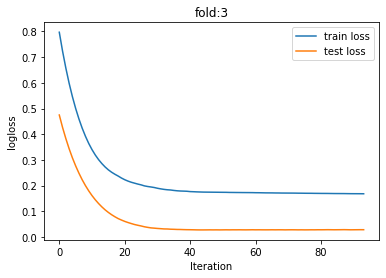

[I 2021-12-12 02:46:19,370] A new study created in memory with name: no-name-17699522-2f52-4865-a948-4dae1d8c1762
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.388546:  14%|#4        | 1/7 [00:00<00:02,  2.07it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.15319	Test's rmse: 0.388546
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  29%|##8       | 2/7 [00:00<00:02,  2.14it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  43%|####2     | 3/7 [00:01<00:01,  2.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121666	Test's rmse: 0.413258
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  57%|#####7    | 4/7 [00:01<00:01,  2.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119068	Test's rmse: 0.407667
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  71%|#######1  | 5/7 [00:02<00:00,  2.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119956	Test's rmse: 0.397927
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  86%|########5 | 6/7 [00:02<00:00,  2.14it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.157903	Test's rmse: 0.380201
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033: 100%|##########| 7/7 [00:03<00:00,  2.20it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127532	Test's rmse: 0.411948


num_leaves, val_score: 0.373033:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:   5%|5         | 1/20 [00:01<00:27,  1.43s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  10%|#         | 2/20 [00:02<00:18,  1.03s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159189	Test's rmse: 0.376066
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  15%|#5        | 3/20 [00:03<00:21,  1.27s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  20%|##        | 4/20 [00:03<00:13,  1.15it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.155086	Test's rmse: 0.354284
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  25%|##5       | 5/20 [00:05<00:17,  1.16s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  30%|###       | 6/20 [00:06<00:15,  1.11s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159188	Test's rmse: 0.37607
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  35%|###5      | 7/20 [00:07<00:12,  1.00it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159189	Test's rmse: 0.376066
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  40%|####      | 8/20 [00:08<00:10,  1.12it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159226	Test's rmse: 0.376113
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  45%|####5     | 9/20 [00:08<00:08,  1.26it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.159509	Test's rmse: 0.374446
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.354284:  50%|#####     | 10/20 [00:10<00:10,  1.05s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  55%|#####5    | 11/20 [00:10<00:07,  1.22it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.161338	Test's rmse: 0.374271
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169751	Test's rmse: 0.343336


num_leaves, val_score: 0.343336:  65%|######5   | 13/20 [00:11<00:03,  1.92it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.15377	Test's rmse: 0.361059
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  70%|#######   | 14/20 [00:12<00:04,  1.42it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153043	Test's rmse: 0.375766
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  75%|#######5  | 15/20 [00:13<00:03,  1.25it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376069
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  80%|########  | 16/20 [00:13<00:02,  1.43it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.159727	Test's rmse: 0.372236
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  85%|########5 | 17/20 [00:13<00:01,  1.76it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.158953	Test's rmse: 0.358268
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  90%|######### | 18/20 [00:15<00:01,  1.24it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336:  95%|#########5| 19/20 [00:16<00:00,  1.18it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153033	Test's rmse: 0.375776
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343336: 100%|##########| 20/20 [00:16<00:00,  1.19it/s]


Early stopping, best iteration is:
[38]	Train's rmse: 0.152838	Test's rmse: 0.373038


bagging, val_score: 0.343336:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.341366:  10%|#         | 1/10 [00:00<00:02,  4.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171177	Test's rmse: 0.341366
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  20%|##        | 2/10 [00:00<00:01,  4.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170925	Test's rmse: 0.337302
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  30%|###       | 3/10 [00:00<00:01,  4.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176927	Test's rmse: 0.3462
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  40%|####      | 4/10 [00:00<00:01,  4.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179848	Test's rmse: 0.359146
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.176908	Test's rmse: 0.354585


bagging, val_score: 0.337302:  50%|#####     | 5/10 [00:01<00:01,  4.44it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  60%|######    | 6/10 [00:01<00:00,  4.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168143	Test's rmse: 0.345755
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  70%|#######   | 7/10 [00:01<00:00,  4.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174192	Test's rmse: 0.340108
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  80%|########  | 8/10 [00:01<00:00,  4.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176644	Test's rmse: 0.361227
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302:  90%|######### | 9/10 [00:02<00:00,  4.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171951	Test's rmse: 0.353581
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.337302: 100%|##########| 10/10 [00:02<00:00,  4.27it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173412	Test's rmse: 0.346694


feature_fraction_stage2, val_score: 0.337302:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.337302:  33%|###3      | 1/3 [00:00<00:00,  4.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172444	Test's rmse: 0.338426
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.335718:  67%|######6   | 2/3 [00:00<00:00,  3.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172974	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.335718: 100%|##########| 3/3 [00:00<00:00,  4.06it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172444	Test's rmse: 0.338426


regularization_factors, val_score: 0.335718:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335718:   5%|5         | 1/20 [00:00<00:04,  4.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17123	Test's rmse: 0.336605
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335718:  10%|#         | 2/20 [00:00<00:04,  4.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172978	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335718:  15%|#5        | 3/20 [00:00<00:04,  3.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170814	Test's rmse: 0.336687
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  20%|##        | 4/20 [00:00<00:03,  4.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172975	Test's rmse: 0.335717
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  25%|##5       | 5/20 [00:01<00:03,  4.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173373	Test's rmse: 0.340647
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  30%|###       | 6/20 [00:01<00:03,  4.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172974	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  35%|###5      | 7/20 [00:01<00:03,  4.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173005	Test's rmse: 0.337889
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  40%|####      | 8/20 [00:01<00:02,  4.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172976	Test's rmse: 0.335717
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  45%|####5     | 9/20 [00:02<00:02,  4.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172974	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  50%|#####     | 10/20 [00:02<00:02,  4.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172974	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  55%|#####5    | 11/20 [00:02<00:02,  4.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172975	Test's rmse: 0.335717
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335717:  60%|######    | 12/20 [00:02<00:01,  4.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172975	Test's rmse: 0.335717
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335714:  65%|######5   | 13/20 [00:03<00:01,  4.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172987	Test's rmse: 0.335714
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335714:  70%|#######   | 14/20 [00:03<00:01,  4.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170965	Test's rmse: 0.337134
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.335714:  75%|#######5  | 15/20 [00:03<00:01,  4.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172975	Test's rmse: 0.335718
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.333169:  80%|########  | 16/20 [00:03<00:00,  4.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175305	Test's rmse: 0.333169
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.333169:  85%|########5 | 17/20 [00:04<00:00,  4.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172326	Test's rmse: 0.337181
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.333169:  90%|######### | 18/20 [00:04<00:00,  4.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175208	Test's rmse: 0.335476
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.333169:  95%|#########5| 19/20 [00:04<00:00,  4.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180125	Test's rmse: 0.335286
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.333169: 100%|##########| 20/20 [00:04<00:00,  4.16it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180153	Test's rmse: 0.336557


min_data_in_leaf, val_score: 0.333169:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.333169:  20%|##        | 1/5 [00:00<00:01,  3.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157542	Test's rmse: 0.347682
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.333156:  40%|####      | 2/5 [00:00<00:00,  4.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181055	Test's rmse: 0.333156
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.333156:  60%|######    | 3/5 [00:00<00:00,  4.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162504	Test's rmse: 0.338551
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.333156:  80%|########  | 4/5 [00:00<00:00,  4.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.25024	Test's rmse: 0.476842
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.333156: 100%|##########| 5/5 [00:01<00:00,  4.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.213971	Test's rmse: 0.431786


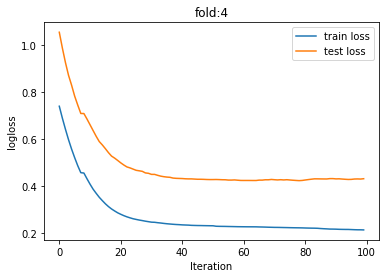

RMSE: [0.3283616499658815, 0.09204166165281427, 0.13812988298145246, 0.019712231693102582, 0.3331558716653759]
RMSE: 0.18228025959172536


In [ ]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_opt = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt.append(rmse)

print("RMSE:", cv_result_opt)
print("RMSE:", np.mean(cv_result_opt))

## Optuna によるハイパーパラメーターチューニング

In [ ]:
def objective(trial):

    learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1.0)
    num_leaves =  trial.suggest_int("num_leaves", 5, 50)
    tree_learner = trial.suggest_categorical('tree_learner', ["serial", "feature", "data", "voting"])

    params = {
            'task': 'train',                 # タスクを訓練に設定
            'boosting_type': 'gbdt',         # GBDTを指定
            'objective': 'regression',       # 回帰を指定
            'metric': {'rmse'},              # 回帰の損失（誤差）
            'learning_rate': learning_rate,  # 学習率
            'num_leaves': num_leaves,
            'tree_learner': tree_learner,
            'seed': SEED                     # シード値
            }

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )
    
    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)

    return rmse

[I 2021-12-12 02:46:48,948] A new study created in memory with name: no-name-52fd1db5-fe9d-4586-94ba-f79167f43516


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:49,152] Trial 0 finished with value: 0.3362880591516736 and parameters: {'learning_rate': 0.9908370333158163, 'num_leaves': 20, 'tree_learner': 'serial'}. Best is trial 0 with value: 0.3362880591516736.


Early stopping, best iteration is:
[17]	Train's rmse: 0.12222	Test's rmse: 0.336288
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:49,400] Trial 1 finished with value: 0.3475316569155363 and parameters: {'learning_rate': 0.23308185371586515, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.3362880591516736.


Early stopping, best iteration is:
[15]	Train's rmse: 0.149192	Test's rmse: 0.347532
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:49,669] Trial 2 finished with value: 0.35092130923900716 and parameters: {'learning_rate': 0.3679367102402814, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 0 with value: 0.3362880591516736.
[I 2021-12-12 02:46:49,804] Trial 3 finished with value: 0.3478238822692373 and parameters: {'learning_rate': 0.734228896248205, 'num_leaves': 19, 'tree_learner': 'voting'}. Best is trial 0 with value: 0.3362880591516736.


Early stopping, best iteration is:
[6]	Train's rmse: 0.168844	Test's rmse: 0.350921
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.175001	Test's rmse: 0.347824
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:50,026] Trial 4 finished with value: 0.3352494322949689 and parameters: {'learning_rate': 0.8699724773623708, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 4 with value: 0.3352494322949689.


Early stopping, best iteration is:
[6]	Train's rmse: 0.147118	Test's rmse: 0.335249
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:50,322] Trial 5 finished with value: 0.3496905982843817 and parameters: {'learning_rate': 0.2018245402832104, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.3352494322949689.


Early stopping, best iteration is:
[21]	Train's rmse: 0.148303	Test's rmse: 0.349691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:50,588] Trial 6 finished with value: 0.3314876278336539 and parameters: {'learning_rate': 0.5043332350102016, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.
[I 2021-12-12 02:46:50,695] Trial 7 finished with value: 0.3382626748218088 and parameters: {'learning_rate': 0.3285832511665075, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[10]	Train's rmse: 0.134302	Test's rmse: 0.331488
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.160721	Test's rmse: 0.338263
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:50,943] Trial 8 finished with value: 0.3482210375545659 and parameters: {'learning_rate': 0.33622743908338937, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[14]	Train's rmse: 0.149711	Test's rmse: 0.348221
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:51,258] Trial 9 finished with value: 0.33225481401365614 and parameters: {'learning_rate': 0.4777742702567739, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.
[I 2021-12-12 02:46:51,406] Trial 10 finished with value: 0.346844961372521 and parameters: {'learning_rate': 0.5894815596766031, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[19]	Train's rmse: 0.125706	Test's rmse: 0.332255
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.171799	Test's rmse: 0.346845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:51,693] Trial 11 finished with value: 0.3345461361324125 and parameters: {'learning_rate': 0.5398808029048686, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[8]	Train's rmse: 0.145158	Test's rmse: 0.334546
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:51,984] Trial 12 finished with value: 0.3324588301197215 and parameters: {'learning_rate': 0.5276530014616095, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[11]	Train's rmse: 0.133779	Test's rmse: 0.332459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:52,216] Trial 13 finished with value: 0.34231255321728166 and parameters: {'learning_rate': 0.6681785002063154, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[3]	Train's rmse: 0.164665	Test's rmse: 0.342313
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:52,492] Trial 14 finished with value: 0.3369662983062257 and parameters: {'learning_rate': 0.453792927874429, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[11]	Train's rmse: 0.137282	Test's rmse: 0.336966
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:52,955] Trial 15 finished with value: 0.3444561254300842 and parameters: {'learning_rate': 0.10980611742433544, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.
[I 2021-12-12 02:46:53,111] Trial 16 finished with value: 0.3472571665587087 and parameters: {'learning_rate': 0.7356912391726833, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[38]	Train's rmse: 0.145237	Test's rmse: 0.344456
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.173727	Test's rmse: 0.347257
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:53,444] Trial 17 finished with value: 0.34145404286915937 and parameters: {'learning_rate': 0.43317057713943624, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[32]	Train's rmse: 0.12391	Test's rmse: 0.341454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:53,703] Trial 18 finished with value: 0.3431290186208778 and parameters: {'learning_rate': 0.6478818966375968, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 6 with value: 0.3314876278336539.
[I 2021-12-12 02:46:53,883] Trial 19 finished with value: 0.3394125204769424 and parameters: {'learning_rate': 0.47373021355478184, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[3]	Train's rmse: 0.165827	Test's rmse: 0.343129
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.159671	Test's rmse: 0.339413


[I 2021-12-12 02:46:54,001] Trial 20 finished with value: 0.33303590834265406 and parameters: {'learning_rate': 0.8312717021669336, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	Train's rmse: 0.108728	Test's rmse: 0.333036
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:54,275] Trial 21 finished with value: 0.3317925888215943 and parameters: {'learning_rate': 0.5263597168776509, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[12]	Train's rmse: 0.132325	Test's rmse: 0.331793
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:54,519] Trial 22 finished with value: 0.3460483927937558 and parameters: {'learning_rate': 0.601013740301753, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[3]	Train's rmse: 0.169975	Test's rmse: 0.346048
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:54,841] Trial 23 finished with value: 0.3437811037629939 and parameters: {'learning_rate': 0.39524209989279707, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.3314876278336539.


Early stopping, best iteration is:
[24]	Train's rmse: 0.131328	Test's rmse: 0.343781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:55,103] Trial 24 finished with value: 0.33021222357307617 and parameters: {'learning_rate': 0.49958333077839084, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.33021222357307617.


Early stopping, best iteration is:
[10]	Train's rmse: 0.133263	Test's rmse: 0.330212
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:55,485] Trial 25 finished with value: 0.34897604326517473 and parameters: {'learning_rate': 0.5349378515530822, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.33021222357307617.


Early stopping, best iteration is:
[41]	Train's rmse: 0.109166	Test's rmse: 0.348976
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:55,708] Trial 26 finished with value: 0.34197801671412364 and parameters: {'learning_rate': 0.6796125765753254, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 24 with value: 0.33021222357307617.


Early stopping, best iteration is:
[3]	Train's rmse: 0.164189	Test's rmse: 0.341978
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:56,065] Trial 27 finished with value: 0.3476826725113396 and parameters: {'learning_rate': 0.27500235962912417, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 24 with value: 0.33021222357307617.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105391	Test's rmse: 0.347683
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:56,312] Trial 28 finished with value: 0.3419556864574393 and parameters: {'learning_rate': 0.5881326260670029, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 24 with value: 0.33021222357307617.
[I 2021-12-12 02:46:56,458] Trial 29 finished with value: 0.35503590708093624 and parameters: {'learning_rate': 0.9152224265445053, 'num_leaves': 23, 'tree_learner': 'serial'}. Best is trial 24 with value: 0.33021222357307617.


Early stopping, best iteration is:
[6]	Train's rmse: 0.15186	Test's rmse: 0.341956
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.150913	Test's rmse: 0.355036
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:56,613] Trial 30 finished with value: 0.32706618506768675 and parameters: {'learning_rate': 0.7670415590966797, 'num_leaves': 14, 'tree_learner': 'serial'}. Best is trial 30 with value: 0.32706618506768675.
[I 2021-12-12 02:46:56,740] Trial 31 finished with value: 0.34363758544542283 and parameters: {'learning_rate': 0.8125540010692589, 'num_leaves': 12, 'tree_learner': 'serial'}. Best is trial 30 with value: 0.32706618506768675.


Early stopping, best iteration is:
[24]	Train's rmse: 0.106323	Test's rmse: 0.327066
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.172084	Test's rmse: 0.343638
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:56,863] Trial 32 finished with value: 0.34521199160250055 and parameters: {'learning_rate': 0.9755606758561073, 'num_leaves': 15, 'tree_learner': 'serial'}. Best is trial 30 with value: 0.32706618506768675.
[I 2021-12-12 02:46:56,989] Trial 33 finished with value: 0.3486066274068783 and parameters: {'learning_rate': 0.730029487505834, 'num_leaves': 18, 'tree_learner': 'serial'}. Best is trial 30 with value: 0.32706618506768675.


Early stopping, best iteration is:
[1]	Train's rmse: 0.175924	Test's rmse: 0.345212
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.175872	Test's rmse: 0.348607
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:57,148] Trial 34 finished with value: 0.3362697305037134 and parameters: {'learning_rate': 0.4242135268080591, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 30 with value: 0.32706618506768675.
[I 2021-12-12 02:46:57,233] Trial 35 finished with value: 0.32895795995521765 and parameters: {'learning_rate': 0.5090408025489345, 'num_leaves': 6, 'tree_learner': 'feature'}. Best is trial 30 with value: 0.32706618506768675.
[I 2021-12-12 02:46:57,328] Trial 36 finished with value: 0.32684938332320984 and parameters: {'learning_rate': 0.6100714817557646, 'num_leaves': 8, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[6]	Train's rmse: 0.156546	Test's rmse: 0.33627
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	Train's rmse: 0.154247	Test's rmse: 0.328958
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.163259	Test's rmse: 0.326849


[I 2021-12-12 02:46:57,418] Trial 37 finished with value: 0.33257876538109693 and parameters: {'learning_rate': 0.7907359700088268, 'num_leaves': 6, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:57,510] Trial 38 finished with value: 0.3472902541878726 and parameters: {'learning_rate': 0.6323039496265876, 'num_leaves': 9, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.196847	Test's rmse: 0.332579
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.1742	Test's rmse: 0.34729
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:57,676] Trial 39 finished with value: 0.3432963200344637 and parameters: {'learning_rate': 0.713140435941436, 'num_leaves': 15, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:57,794] Trial 40 finished with value: 0.33942734078249437 and parameters: {'learning_rate': 0.7787939946464353, 'num_leaves': 8, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[29]	Train's rmse: 0.106432	Test's rmse: 0.343296
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.16073	Test's rmse: 0.339427
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:57,989] Trial 41 finished with value: 0.33599512733248654 and parameters: {'learning_rate': 0.5027280814655524, 'num_leaves': 12, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:58,081] Trial 42 finished with value: 0.3290662119203974 and parameters: {'learning_rate': 0.37204637233913107, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0748984	Test's rmse: 0.335995
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.1577	Test's rmse: 0.329066
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:58,260] Trial 43 finished with value: 0.3444050097133535 and parameters: {'learning_rate': 0.3514165139069374, 'num_leaves': 12, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:58,354] Trial 44 finished with value: 0.33722636244196297 and parameters: {'learning_rate': 0.2835509461177919, 'num_leaves': 7, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[39]	Train's rmse: 0.123656	Test's rmse: 0.344405
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	Train's rmse: 0.154492	Test's rmse: 0.337226
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:58,489] Trial 45 finished with value: 0.3499296452859924 and parameters: {'learning_rate': 0.41158908342328654, 'num_leaves': 15, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:58,601] Trial 46 finished with value: 0.34475257042547325 and parameters: {'learning_rate': 0.5894233554096737, 'num_leaves': 11, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[9]	Train's rmse: 0.151754	Test's rmse: 0.34993
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	Train's rmse: 0.140444	Test's rmse: 0.344753
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	Train's rmse: 0.153161	Test's rmse: 0.340819


[I 2021-12-12 02:46:58,691] Trial 47 finished with value: 0.3408190429278116 and parameters: {'learning_rate': 0.37628485845905096, 'num_leaves': 5, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:58,838] Trial 48 finished with value: 0.3442653402134603 and parameters: {'learning_rate': 0.20502139038765277, 'num_leaves': 9, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[19]	Train's rmse: 0.14736	Test's rmse: 0.344265
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:59,106] Trial 49 finished with value: 0.3490786120256078 and parameters: {'learning_rate': 0.5624853799790511, 'num_leaves': 21, 'tree_learner': 'voting'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:59,251] Trial 50 finished with value: 0.345229406331146 and parameters: {'learning_rate': 0.3010000247367151, 'num_leaves': 14, 'tree_learner': 'data'}. Best is trial 36 with value: 0.32684938332320984.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0729991	Test's rmse: 0.349079
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	Train's rmse: 0.145017	Test's rmse: 0.345229
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:59,347] Trial 51 finished with value: 0.3313869647951364 and parameters: {'learning_rate': 0.48916497426551286, 'num_leaves': 7, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:59,438] Trial 52 finished with value: 0.3397189683826586 and parameters: {'learning_rate': 0.48384695366611075, 'num_leaves': 8, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[8]	Train's rmse: 0.154118	Test's rmse: 0.331387
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.175296	Test's rmse: 0.339719
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:59,579] Trial 53 finished with value: 0.336358727204636 and parameters: {'learning_rate': 0.45226247016177235, 'num_leaves': 18, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:59,697] Trial 54 finished with value: 0.34967629483331397 and parameters: {'learning_rate': 0.5652543271645439, 'num_leaves': 10, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[6]	Train's rmse: 0.155747	Test's rmse: 0.336359
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.159301	Test's rmse: 0.349676
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:46:59,805] Trial 55 finished with value: 0.35812268718811807 and parameters: {'learning_rate': 0.8742810890805328, 'num_leaves': 7, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.
[I 2021-12-12 02:46:59,948] Trial 56 finished with value: 0.3279553084316213 and parameters: {'learning_rate': 0.49574768992653284, 'num_leaves': 6, 'tree_learner': 'feature'}. Best is trial 36 with value: 0.32684938332320984.


Early stopping, best iteration is:
[3]	Train's rmse: 0.182266	Test's rmse: 0.358123
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0475194	Test's rmse: 0.327955
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:00,048] Trial 57 finished with value: 0.31618048667254833 and parameters: {'learning_rate': 0.6192844380426474, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:00,142] Trial 58 finished with value: 0.32260500782481794 and parameters: {'learning_rate': 0.6976119520879668, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:00,224] Trial 59 finished with value: 0.3305583652728237 and parameters: {'learning_rate': 0.6287650773331763, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.


Early stopping, best iteration is:
[13]	Train's rmse: 0.152839	Test's rmse: 0.31618
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[13]	Train's rmse: 0.152998	Test's rmse: 0.322605
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.170626	Test's rmse: 0.330558


[I 2021-12-12 02:47:00,349] Trial 60 finished with value: 0.35245119176432216 and parameters: {'learning_rate': 0.6846114368868366, 'num_leaves': 13, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.151832	Test's rmse: 0.352451
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.18018	Test's rmse: 0.350088


[I 2021-12-12 02:47:00,450] Trial 61 finished with value: 0.3500882178038671 and parameters: {'learning_rate': 0.7521322387212738, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:00,533] Trial 62 finished with value: 0.3250745006613781 and parameters: {'learning_rate': 0.6971129422407011, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:00,621] Trial 63 finished with value: 0.32461824653644183 and parameters: {'learning_rate': 0.6906067626199568, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	Train's rmse: 0.15752	Test's rmse: 0.325074
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	Train's rmse: 0.1436	Test's rmse: 0.324618
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:00,719] Trial 64 finished with value: 0.3250525349123573 and parameters: {'learning_rate': 0.6960137189229841, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:00,901] Trial 65 finished with value: 0.34893793946610924 and parameters: {'learning_rate': 0.7045335290924672, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.


Early stopping, best iteration is:
[18]	Train's rmse: 0.134952	Test's rmse: 0.325053
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0629753	Test's rmse: 0.348938


[I 2021-12-12 02:47:01,033] Trial 66 finished with value: 0.316288462575596 and parameters: {'learning_rate': 0.6481990978062449, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 57 with value: 0.31618048667254833.
[I 2021-12-12 02:47:01,125] Trial 67 finished with value: 0.31119078793952454 and parameters: {'learning_rate': 0.6622823275142123, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[23]	Train's rmse: 0.086482	Test's rmse: 0.316288
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	Train's rmse: 0.112795	Test's rmse: 0.311191


[I 2021-12-12 02:47:01,224] Trial 68 finished with value: 0.3112188871437756 and parameters: {'learning_rate': 0.6588514077746823, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:01,303] Trial 69 finished with value: 0.3306555764254393 and parameters: {'learning_rate': 0.6365309790356376, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	Train's rmse: 0.112854	Test's rmse: 0.311219
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.170663	Test's rmse: 0.330656
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:01,426] Trial 70 finished with value: 0.3508824433937407 and parameters: {'learning_rate': 0.6789380264835082, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:01,519] Trial 71 finished with value: 0.3112255380158781 and parameters: {'learning_rate': 0.6580909803099757, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:01,612] Trial 72 finished with value: 0.32828410114586476 and parameters: {'learning_rate': 0.6595691647020033, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[6]	Train's rmse: 0.142729	Test's rmse: 0.350882
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	Train's rmse: 0.112868	Test's rmse: 0.311226
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	Train's rmse: 0.11004	Test's rmse: 0.328284


[I 2021-12-12 02:47:01,775] Trial 73 finished with value: 0.33052185063028605 and parameters: {'learning_rate': 0.7435578098173597, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0471289	Test's rmse: 0.330522
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:01,904] Trial 74 finished with value: 0.31122232338923467 and parameters: {'learning_rate': 0.658457073998155, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:02,054] Trial 75 finished with value: 0.3420999201043443 and parameters: {'learning_rate': 0.6658300603390144, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[24]	Train's rmse: 0.112861	Test's rmse: 0.311222
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.100873	Test's rmse: 0.3421
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:02,157] Trial 76 finished with value: 0.3303681131794461 and parameters: {'learning_rate': 0.7213523243407769, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:02,328] Trial 77 finished with value: 0.3413959192299193 and parameters: {'learning_rate': 0.6145179453626471, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[6]	Train's rmse: 0.156874	Test's rmse: 0.330368
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[49]	Train's rmse: 0.0768381	Test's rmse: 0.341396
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:02,418] Trial 78 finished with value: 0.33156179969466515 and parameters: {'learning_rate': 0.6527175833726295, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:02,522] Trial 79 finished with value: 0.3276348314575648 and parameters: {'learning_rate': 0.5738544553374059, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[6]	Train's rmse: 0.160049	Test's rmse: 0.331562
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.164164	Test's rmse: 0.327635
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:02,645] Trial 80 finished with value: 0.34212915432029184 and parameters: {'learning_rate': 0.7598703477248772, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:02,740] Trial 81 finished with value: 0.3245047800150545 and parameters: {'learning_rate': 0.6140521740602203, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:02,825] Trial 82 finished with value: 0.3307098562324681 and parameters: {'learning_rate': 0.6125282487337766, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[9]	Train's rmse: 0.131546	Test's rmse: 0.342129
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.132691	Test's rmse: 0.324505
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.17132	Test's rmse: 0.33071


[I 2021-12-12 02:47:02,936] Trial 83 finished with value: 0.32808812084550243 and parameters: {'learning_rate': 0.5424778515370776, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,022] Trial 84 finished with value: 0.3294356218267259 and parameters: {'learning_rate': 0.6425649899542054, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.171993	Test's rmse: 0.328088
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.154343	Test's rmse: 0.329436
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:03,125] Trial 85 finished with value: 0.33155826451983783 and parameters: {'learning_rate': 0.7967187782573683, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,236] Trial 86 finished with value: 0.32754141774965456 and parameters: {'learning_rate': 0.5835328523385224, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[2]	Train's rmse: 0.177424	Test's rmse: 0.331558
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.1639	Test's rmse: 0.327541
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.151635	Test's rmse: 0.331394


[I 2021-12-12 02:47:03,327] Trial 87 finished with value: 0.3313939394038545 and parameters: {'learning_rate': 0.7190548945677144, 'num_leaves': 6, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,416] Trial 88 finished with value: 0.31791387010352545 and parameters: {'learning_rate': 0.6560755157613617, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,513] Trial 89 finished with value: 0.32029783260626116 and parameters: {'learning_rate': 0.6219036822718099, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.134244	Test's rmse: 0.317914
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	Train's rmse: 0.13727	Test's rmse: 0.320298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:03,613] Trial 90 finished with value: 0.3137200444868497 and parameters: {'learning_rate': 0.6556912495363207, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,698] Trial 91 finished with value: 0.31501319352315543 and parameters: {'learning_rate': 0.6641967031794065, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:03,793] Trial 92 finished with value: 0.327989418415854 and parameters: {'learning_rate': 0.6626154495043386, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Early stopping, best iteration is:
[19]	Train's rmse: 0.12913	Test's rmse: 0.31372
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	Train's rmse: 0.15277	Test's rmse: 0.315013
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.159619	Test's rmse: 0.327989


[I 2021-12-12 02:47:03,903] Trial 93 finished with value: 0.33057926891247874 and parameters: {'learning_rate': 0.6304712784846389, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:04,007] Trial 94 finished with value: 0.32499867309313474 and parameters: {'learning_rate': 0.5995172993773591, 'num_leaves': 8, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.170633	Test's rmse: 0.330579
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.124223	Test's rmse: 0.324999


[I 2021-12-12 02:47:04,115] Trial 95 finished with value: 0.345040400990169 and parameters: {'learning_rate': 0.6670552253320648, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:04,209] Trial 96 finished with value: 0.3278003028218825 and parameters: {'learning_rate': 0.6491277074201575, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.170544	Test's rmse: 0.34504
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.159483	Test's rmse: 0.3278
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:04,569] Trial 97 finished with value: 0.34809748417709496 and parameters: {'learning_rate': 0.563131010453829, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0715713	Test's rmse: 0.348097
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[47]	Train's rmse: 0.142028	Test's rmse: 0.346545


[I 2021-12-12 02:47:04,750] Trial 98 finished with value: 0.34654549713753047 and parameters: {'learning_rate': 0.10778078528199969, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.
[I 2021-12-12 02:47:04,827] Trial 99 finished with value: 0.32672785613757027 and parameters: {'learning_rate': 0.7304626537830977, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 67 with value: 0.31119078793952454.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.184803	Test's rmse: 0.326728
{'learning_rate': 0.6622823275142123, 'num_leaves': 5, 'tree_learner': 'voting'}
{'learning_rate': 0.6622823275142123, 'num_leaves': 5, 'tree_learner': 'voting', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	Train's rmse: 0.112795	Test's rmse: 0.311191


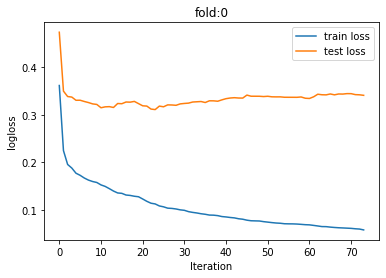

[I 2021-12-12 02:47:05,135] A new study created in memory with name: no-name-4d727a0f-5a36-4e8a-a4f6-7bd2cfc7866a
[I 2021-12-12 02:47:05,298] Trial 0 finished with value: 0.12189624256950594 and parameters: {'learning_rate': 0.9941040040703081, 'num_leaves': 13, 'tree_learner': 'serial'}. Best is trial 0 with value: 0.12189624256950594.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	Train's rmse: 0.153932	Test's rmse: 0.121896
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:05,463] Trial 1 finished with value: 0.11308166969650284 and parameters: {'learning_rate': 0.6853308468128014, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 1 with value: 0.11308166969650284.
[I 2021-12-12 02:47:05,634] Trial 2 finished with value: 0.11755418640822302 and parameters: {'learning_rate': 0.6546845605202262, 'num_leaves': 19, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.11308166969650284.


Early stopping, best iteration is:
[18]	Train's rmse: 0.136355	Test's rmse: 0.113082
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	Train's rmse: 0.135455	Test's rmse: 0.117554
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:05,895] Trial 3 finished with value: 0.13339205180409322 and parameters: {'learning_rate': 0.2349022955200804, 'num_leaves': 19, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.11308166969650284.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117739	Test's rmse: 0.133392
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:06,168] Trial 4 finished with value: 0.13174961241713054 and parameters: {'learning_rate': 0.784028626842111, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.11308166969650284.


Early stopping, best iteration is:
[8]	Train's rmse: 0.169644	Test's rmse: 0.13175
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:06,580] Trial 5 finished with value: 0.11533904257321792 and parameters: {'learning_rate': 0.26982222077445445, 'num_leaves': 40, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.11308166969650284.


Early stopping, best iteration is:
[49]	Train's rmse: 0.142868	Test's rmse: 0.115339
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:07,112] Trial 6 finished with value: 0.10434864184439116 and parameters: {'learning_rate': 0.1336685049958195, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144692	Test's rmse: 0.104349
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:07,409] Trial 7 finished with value: 0.1258139212640273 and parameters: {'learning_rate': 0.8953486299571178, 'num_leaves': 47, 'tree_learner': 'data'}. Best is trial 6 with value: 0.10434864184439116.
[I 2021-12-12 02:47:07,542] Trial 8 finished with value: 0.11398719507411242 and parameters: {'learning_rate': 0.24719874212101733, 'num_leaves': 8, 'tree_learner': 'data'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[15]	Train's rmse: 0.142569	Test's rmse: 0.125814
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.144657	Test's rmse: 0.113987
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:08,054] Trial 9 finished with value: 0.13390352334092784 and parameters: {'learning_rate': 0.2707748956584707, 'num_leaves': 49, 'tree_learner': 'data'}. Best is trial 6 with value: 0.10434864184439116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.10736	Test's rmse: 0.133904
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:08,328] Trial 10 finished with value: 0.10899901438807813 and parameters: {'learning_rate': 0.4164747632062251, 'num_leaves': 34, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[25]	Train's rmse: 0.145408	Test's rmse: 0.108999
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:08,556] Trial 11 finished with value: 0.1214659549959337 and parameters: {'learning_rate': 0.45010943419435845, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[6]	Train's rmse: 0.180355	Test's rmse: 0.121466
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:08,965] Trial 12 finished with value: 0.11255211942270973 and parameters: {'learning_rate': 0.10902660404066546, 'num_leaves': 31, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148004	Test's rmse: 0.112552
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:09,275] Trial 13 finished with value: 0.11345845718262103 and parameters: {'learning_rate': 0.44639867404229855, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[23]	Train's rmse: 0.149385	Test's rmse: 0.113458
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:09,571] Trial 14 finished with value: 0.10909272267158102 and parameters: {'learning_rate': 0.4415927574315189, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147313	Test's rmse: 0.109093
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:09,890] Trial 15 finished with value: 0.11945375418985003 and parameters: {'learning_rate': 0.1542346632358864, 'num_leaves': 24, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133554	Test's rmse: 0.119454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:10,295] Trial 16 finished with value: 0.11401817811362942 and parameters: {'learning_rate': 0.3558559386433464, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[36]	Train's rmse: 0.144902	Test's rmse: 0.114018
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:10,559] Trial 17 finished with value: 0.11478483591250851 and parameters: {'learning_rate': 0.5739711963907821, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[18]	Train's rmse: 0.161803	Test's rmse: 0.114785
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:10,806] Trial 18 finished with value: 0.11114650314364462 and parameters: {'learning_rate': 0.3648388312033243, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[29]	Train's rmse: 0.146536	Test's rmse: 0.111147
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:11,126] Trial 19 finished with value: 0.11437187013044497 and parameters: {'learning_rate': 0.5949947563507696, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[17]	Train's rmse: 0.160104	Test's rmse: 0.114372
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:11,486] Trial 20 finished with value: 0.11104689206977439 and parameters: {'learning_rate': 0.15373530421234105, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133822	Test's rmse: 0.111047
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:11,711] Trial 21 finished with value: 0.12193181096135315 and parameters: {'learning_rate': 0.4559811790397184, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[6]	Train's rmse: 0.179972	Test's rmse: 0.121932
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:12,067] Trial 22 finished with value: 0.1110041789107374 and parameters: {'learning_rate': 0.3484804036608985, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[34]	Train's rmse: 0.146051	Test's rmse: 0.111004
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:12,367] Trial 23 finished with value: 0.11043130993989218 and parameters: {'learning_rate': 0.5168662943942057, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[22]	Train's rmse: 0.144241	Test's rmse: 0.110431
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:12,698] Trial 24 finished with value: 0.11305012777580356 and parameters: {'learning_rate': 0.5024118022399046, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 6 with value: 0.10434864184439116.


Early stopping, best iteration is:
[18]	Train's rmse: 0.152379	Test's rmse: 0.11305
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:13,013] Trial 25 finished with value: 0.10406013281424457 and parameters: {'learning_rate': 0.4171876484018003, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[34]	Train's rmse: 0.134491	Test's rmse: 0.10406
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:13,274] Trial 26 finished with value: 0.11946804458070859 and parameters: {'learning_rate': 0.3353790043055929, 'num_leaves': 25, 'tree_learner': 'feature'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[31]	Train's rmse: 0.153718	Test's rmse: 0.119468
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:13,514] Trial 27 finished with value: 0.11958871163589599 and parameters: {'learning_rate': 0.7336626929967076, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[17]	Train's rmse: 0.150197	Test's rmse: 0.119589
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:13,812] Trial 28 finished with value: 0.11749775862252691 and parameters: {'learning_rate': 0.1750915429580631, 'num_leaves': 22, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127675	Test's rmse: 0.117498
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[32]	Train's rmse: 0.149773	Test's rmse: 0.109176


[I 2021-12-12 02:47:13,995] Trial 29 finished with value: 0.10917646451629254 and parameters: {'learning_rate': 0.3912800240562614, 'num_leaves': 14, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.
[I 2021-12-12 02:47:14,191] Trial 30 finished with value: 0.14007162076221572 and parameters: {'learning_rate': 0.9175835627892941, 'num_leaves': 29, 'tree_learner': 'feature'}. Best is trial 25 with value: 0.10406013281424457.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.195947	Test's rmse: 0.140072
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:14,512] Trial 31 finished with value: 0.1108708161060597 and parameters: {'learning_rate': 0.6183852139093462, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[22]	Train's rmse: 0.140139	Test's rmse: 0.110871
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:14,842] Trial 32 finished with value: 0.10807823716977208 and parameters: {'learning_rate': 0.41424022296761126, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[29]	Train's rmse: 0.142258	Test's rmse: 0.108078
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:15,130] Trial 33 finished with value: 0.1096112748569611 and parameters: {'learning_rate': 0.5147836392758544, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[25]	Train's rmse: 0.140986	Test's rmse: 0.109611
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:15,443] Trial 34 finished with value: 0.10511438816170149 and parameters: {'learning_rate': 0.28455885084906185, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[40]	Train's rmse: 0.140127	Test's rmse: 0.105114
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:15,796] Trial 35 finished with value: 0.1187607711294141 and parameters: {'learning_rate': 0.22237179422513834, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117035	Test's rmse: 0.118761
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:16,035] Trial 36 finished with value: 0.11788536088083701 and parameters: {'learning_rate': 0.20541391577909382, 'num_leaves': 16, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.117167	Test's rmse: 0.117885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:16,324] Trial 37 finished with value: 0.10856721289175196 and parameters: {'learning_rate': 0.30751864986602595, 'num_leaves': 21, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.
[I 2021-12-12 02:47:16,489] Trial 38 finished with value: 0.14061318512512488 and parameters: {'learning_rate': 0.2928935537354802, 'num_leaves': 8, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[45]	Train's rmse: 0.13456	Test's rmse: 0.108567
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108048	Test's rmse: 0.140613
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:16,884] Trial 39 finished with value: 0.11497104253437222 and parameters: {'learning_rate': 0.10665673643292403, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151253	Test's rmse: 0.114971
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:17,283] Trial 40 finished with value: 0.11650898900152663 and parameters: {'learning_rate': 0.2982394418584361, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[35]	Train's rmse: 0.142383	Test's rmse: 0.116509
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:17,506] Trial 41 finished with value: 0.11905954227942521 and parameters: {'learning_rate': 0.3211110425904714, 'num_leaves': 21, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[33]	Train's rmse: 0.143627	Test's rmse: 0.11906
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:17,739] Trial 42 finished with value: 0.11872568462024913 and parameters: {'learning_rate': 0.24972031348530657, 'num_leaves': 18, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[48]	Train's rmse: 0.143705	Test's rmse: 0.118726
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:17,965] Trial 43 finished with value: 0.11469090620652492 and parameters: {'learning_rate': 0.3972622894380262, 'num_leaves': 22, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.
[I 2021-12-12 02:47:18,147] Trial 44 finished with value: 0.1235039773369692 and parameters: {'learning_rate': 0.19874456406424013, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[32]	Train's rmse: 0.141949	Test's rmse: 0.114691
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123134	Test's rmse: 0.123504
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:18,476] Trial 45 finished with value: 0.11213801445527151 and parameters: {'learning_rate': 0.27659778818116554, 'num_leaves': 27, 'tree_learner': 'data'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[44]	Train's rmse: 0.142171	Test's rmse: 0.112138
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:18,784] Trial 46 finished with value: 0.11005164672297454 and parameters: {'learning_rate': 0.47910025869732265, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[17]	Train's rmse: 0.155226	Test's rmse: 0.110052
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:19,043] Trial 47 finished with value: 0.10886211848446765 and parameters: {'learning_rate': 0.40381576010200004, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[25]	Train's rmse: 0.146686	Test's rmse: 0.108862
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:19,382] Trial 48 finished with value: 0.11108313510522234 and parameters: {'learning_rate': 0.1380465659239707, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141691	Test's rmse: 0.111083
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:19,635] Trial 49 finished with value: 0.10992235576314088 and parameters: {'learning_rate': 0.24754001446054516, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 25 with value: 0.10406013281424457.
[I 2021-12-12 02:47:19,743] Trial 50 finished with value: 0.11689302346035686 and parameters: {'learning_rate': 0.30825417040334274, 'num_leaves': 5, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[39]	Train's rmse: 0.145549	Test's rmse: 0.109922
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[37]	Train's rmse: 0.14071	Test's rmse: 0.116893
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:20,041] Trial 51 finished with value: 0.12703225428570575 and parameters: {'learning_rate': 0.414900430253903, 'num_leaves': 31, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[32]	Train's rmse: 0.141427	Test's rmse: 0.127032
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:20,336] Trial 52 finished with value: 0.11152780302733946 and parameters: {'learning_rate': 0.5495035053911065, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[18]	Train's rmse: 0.154715	Test's rmse: 0.111528
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:20,660] Trial 53 finished with value: 0.12114708286375307 and parameters: {'learning_rate': 0.379026558081329, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[34]	Train's rmse: 0.144871	Test's rmse: 0.121147
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:20,962] Trial 54 finished with value: 0.11063188544769528 and parameters: {'learning_rate': 0.42750995677148673, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[32]	Train's rmse: 0.144711	Test's rmse: 0.110632
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:21,226] Trial 55 finished with value: 0.10775579397488012 and parameters: {'learning_rate': 0.4797825691002069, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[30]	Train's rmse: 0.135078	Test's rmse: 0.107756
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:21,467] Trial 56 finished with value: 0.11372194691803063 and parameters: {'learning_rate': 0.6453772965705205, 'num_leaves': 28, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[18]	Train's rmse: 0.140017	Test's rmse: 0.113722
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.155408	Test's rmse: 0.112019


[I 2021-12-12 02:47:21,673] Trial 57 finished with value: 0.11201858181410294 and parameters: {'learning_rate': 0.46986988843650396, 'num_leaves': 24, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:21,915] Trial 58 finished with value: 0.12163576938951337 and parameters: {'learning_rate': 0.3312954479355654, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[26]	Train's rmse: 0.1566	Test's rmse: 0.121636
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:22,207] Trial 59 finished with value: 0.11463626441976706 and parameters: {'learning_rate': 0.3535085423075015, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[34]	Train's rmse: 0.145186	Test's rmse: 0.114636
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:22,555] Trial 60 finished with value: 0.10999535241804508 and parameters: {'learning_rate': 0.5584719244144137, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[20]	Train's rmse: 0.152178	Test's rmse: 0.109995
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:22,852] Trial 61 finished with value: 0.1115408080306446 and parameters: {'learning_rate': 0.42888731496417365, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[29]	Train's rmse: 0.148044	Test's rmse: 0.111541
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:23,150] Trial 62 finished with value: 0.10877041623877232 and parameters: {'learning_rate': 0.48964695450548146, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[19]	Train's rmse: 0.151983	Test's rmse: 0.10877
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:23,455] Trial 63 finished with value: 0.11015298534414857 and parameters: {'learning_rate': 0.4996208411458757, 'num_leaves': 39, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[23]	Train's rmse: 0.145919	Test's rmse: 0.110153
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:23,731] Trial 64 finished with value: 0.11029373905645429 and parameters: {'learning_rate': 0.5420869648532298, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[22]	Train's rmse: 0.150287	Test's rmse: 0.110294
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:24,011] Trial 65 finished with value: 0.1124768604999885 and parameters: {'learning_rate': 0.4680719723997203, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[17]	Train's rmse: 0.15546	Test's rmse: 0.112477
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:24,325] Trial 66 finished with value: 0.11560138465877524 and parameters: {'learning_rate': 0.5941210005448461, 'num_leaves': 48, 'tree_learner': 'data'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[17]	Train's rmse: 0.160156	Test's rmse: 0.115601
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:24,618] Trial 67 finished with value: 0.10681272626038055 and parameters: {'learning_rate': 0.3718510882711755, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[31]	Train's rmse: 0.145837	Test's rmse: 0.106813
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:24,907] Trial 68 finished with value: 0.1151128763222305 and parameters: {'learning_rate': 0.3662597820693491, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[29]	Train's rmse: 0.150415	Test's rmse: 0.115113
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:25,213] Trial 69 finished with value: 0.1170347947151681 and parameters: {'learning_rate': 0.27497065082651134, 'num_leaves': 27, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[41]	Train's rmse: 0.146972	Test's rmse: 0.117035
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:25,492] Trial 70 finished with value: 0.12479639222640891 and parameters: {'learning_rate': 0.17545361825766764, 'num_leaves': 17, 'tree_learner': 'feature'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123056	Test's rmse: 0.124796
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:25,762] Trial 71 finished with value: 0.10884519116644782 and parameters: {'learning_rate': 0.4382773925767711, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147478	Test's rmse: 0.108845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:26,021] Trial 72 finished with value: 0.1120892825336714 and parameters: {'learning_rate': 0.5198558696150347, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[24]	Train's rmse: 0.141113	Test's rmse: 0.112089
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:26,336] Trial 73 finished with value: 0.12224838869670875 and parameters: {'learning_rate': 0.3896592487094475, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[27]	Train's rmse: 0.151318	Test's rmse: 0.122248
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:26,552] Trial 74 finished with value: 0.11549039200206798 and parameters: {'learning_rate': 0.4934606762100408, 'num_leaves': 25, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[12]	Train's rmse: 0.159643	Test's rmse: 0.11549
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:26,810] Trial 75 finished with value: 0.12217457211906671 and parameters: {'learning_rate': 0.4569158765028985, 'num_leaves': 44, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[6]	Train's rmse: 0.179911	Test's rmse: 0.122175
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:27,113] Trial 76 finished with value: 0.11194784493691702 and parameters: {'learning_rate': 0.33522796469804367, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[41]	Train's rmse: 0.141912	Test's rmse: 0.111948
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:27,502] Trial 77 finished with value: 0.1295165571055266 and parameters: {'learning_rate': 0.22838723395448982, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116543	Test's rmse: 0.129517
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:27,953] Trial 78 finished with value: 0.11445807960833784 and parameters: {'learning_rate': 0.31326245924746116, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[42]	Train's rmse: 0.141924	Test's rmse: 0.114458
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:28,294] Trial 79 finished with value: 0.12066869339479554 and parameters: {'learning_rate': 0.3757381292684044, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[34]	Train's rmse: 0.145302	Test's rmse: 0.120669
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:28,579] Trial 80 finished with value: 0.12187804089925204 and parameters: {'learning_rate': 0.8406432087957509, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[21]	Train's rmse: 0.132786	Test's rmse: 0.121878
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:28,887] Trial 81 finished with value: 0.11745874323569327 and parameters: {'learning_rate': 0.42220522616600326, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[30]	Train's rmse: 0.143974	Test's rmse: 0.117459
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:29,101] Trial 82 finished with value: 0.12181701374515795 and parameters: {'learning_rate': 0.4539430537839102, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[6]	Train's rmse: 0.1801	Test's rmse: 0.121817
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:29,411] Trial 83 finished with value: 0.1082600539333691 and parameters: {'learning_rate': 0.4436830693927969, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[21]	Train's rmse: 0.147314	Test's rmse: 0.10826
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:29,734] Trial 84 finished with value: 0.10877719206284324 and parameters: {'learning_rate': 0.5343336981892677, 'num_leaves': 40, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[20]	Train's rmse: 0.150793	Test's rmse: 0.108777
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:30,233] Trial 85 finished with value: 0.11216642510312358 and parameters: {'learning_rate': 0.12876519549858245, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144401	Test's rmse: 0.112166
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:30,540] Trial 86 finished with value: 0.11154322387264169 and parameters: {'learning_rate': 0.4840647269804408, 'num_leaves': 41, 'tree_learner': 'data'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[21]	Train's rmse: 0.148735	Test's rmse: 0.111543
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:30,892] Trial 87 finished with value: 0.11144396105312056 and parameters: {'learning_rate': 0.34843380139826474, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[36]	Train's rmse: 0.143477	Test's rmse: 0.111444
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:31,100] Trial 88 finished with value: 0.12656782019087942 and parameters: {'learning_rate': 0.9886247521119651, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[4]	Train's rmse: 0.186377	Test's rmse: 0.126568
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:31,393] Trial 89 finished with value: 0.12697789710894 and parameters: {'learning_rate': 0.41306254469277426, 'num_leaves': 31, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[33]	Train's rmse: 0.142072	Test's rmse: 0.126978
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:31,830] Trial 90 finished with value: 0.10875292348588661 and parameters: {'learning_rate': 0.28336319896656803, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[41]	Train's rmse: 0.140448	Test's rmse: 0.108753
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:32,254] Trial 91 finished with value: 0.11118721483455817 and parameters: {'learning_rate': 0.2650899149249399, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[43]	Train's rmse: 0.145507	Test's rmse: 0.111187
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:32,730] Trial 92 finished with value: 0.10846068887819699 and parameters: {'learning_rate': 0.28513748246671633, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[41]	Train's rmse: 0.140694	Test's rmse: 0.108461
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:33,251] Trial 93 finished with value: 0.11764960312065709 and parameters: {'learning_rate': 0.1867522117568442, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126333	Test's rmse: 0.11765
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:33,718] Trial 94 finished with value: 0.11617095612534523 and parameters: {'learning_rate': 0.29888846239761785, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[46]	Train's rmse: 0.133965	Test's rmse: 0.116171
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:34,174] Trial 95 finished with value: 0.10869080338178735 and parameters: {'learning_rate': 0.2856648623209666, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[48]	Train's rmse: 0.137723	Test's rmse: 0.108691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:34,648] Trial 96 finished with value: 0.11210471243687901 and parameters: {'learning_rate': 0.2581006219404007, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[49]	Train's rmse: 0.142105	Test's rmse: 0.112105
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:35,161] Trial 97 finished with value: 0.12640738190969925 and parameters: {'learning_rate': 0.21268704813615277, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 25 with value: 0.10406013281424457.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114735	Test's rmse: 0.126407
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:35,600] Trial 98 finished with value: 0.10642276282599684 and parameters: {'learning_rate': 0.32288800301780207, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[44]	Train's rmse: 0.142371	Test's rmse: 0.106423
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:35,856] Trial 99 finished with value: 0.11947342251383242 and parameters: {'learning_rate': 0.3969438020391042, 'num_leaves': 23, 'tree_learner': 'serial'}. Best is trial 25 with value: 0.10406013281424457.


Early stopping, best iteration is:
[34]	Train's rmse: 0.135953	Test's rmse: 0.119473
{'learning_rate': 0.4171876484018003, 'num_leaves': 34, 'tree_learner': 'serial'}
{'learning_rate': 0.4171876484018003, 'num_leaves': 34, 'tree_learner': 'serial', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	Train's rmse: 0.134491	Test's rmse: 0.10406


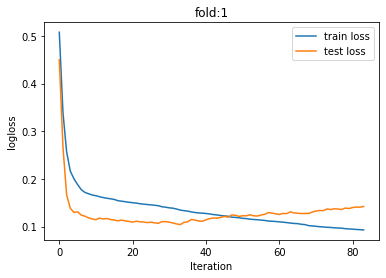

[I 2021-12-12 02:47:36,346] A new study created in memory with name: no-name-937063a6-e1c2-40ea-808b-d21fb52b27fc


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:36,785] Trial 0 finished with value: 0.148807093261481 and parameters: {'learning_rate': 0.2975739203108436, 'num_leaves': 35, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.148807093261481.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113888	Test's rmse: 0.148807
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:36,991] Trial 1 finished with value: 0.125405718889137 and parameters: {'learning_rate': 0.5209989667657369, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.125405718889137.


Early stopping, best iteration is:
[21]	Train's rmse: 0.159419	Test's rmse: 0.125406
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:37,383] Trial 2 finished with value: 0.13020902568424306 and parameters: {'learning_rate': 0.9469250934461972, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 1 with value: 0.125405718889137.


Early stopping, best iteration is:
[8]	Train's rmse: 0.166389	Test's rmse: 0.130209
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:37,791] Trial 3 finished with value: 0.13777015233691578 and parameters: {'learning_rate': 0.34032823549806934, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.125405718889137.


Early stopping, best iteration is:
[48]	Train's rmse: 0.142818	Test's rmse: 0.13777
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[19]	Train's rmse: 0.133382	Test's rmse: 0.112946

[I 2021-12-12 02:47:37,987] Trial 4 finished with value: 0.11294602788088624 and parameters: {'learning_rate': 0.838517808292823, 'num_leaves': 25, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.



Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:38,341] Trial 5 finished with value: 0.11793335165346272 and parameters: {'learning_rate': 0.5348402104666261, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[34]	Train's rmse: 0.138543	Test's rmse: 0.117933
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:38,696] Trial 6 finished with value: 0.12957541889534135 and parameters: {'learning_rate': 0.5526531950553576, 'num_leaves': 48, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[26]	Train's rmse: 0.149853	Test's rmse: 0.129575
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:38,945] Trial 7 finished with value: 0.11924151105582824 and parameters: {'learning_rate': 0.9520519406659718, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[10]	Train's rmse: 0.160953	Test's rmse: 0.119242
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:39,227] Trial 8 finished with value: 0.13057571652572172 and parameters: {'learning_rate': 0.8155531530834333, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[8]	Train's rmse: 0.172861	Test's rmse: 0.130576
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:39,635] Trial 9 finished with value: 0.13658481394203098 and parameters: {'learning_rate': 0.4292289078978919, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:39,765] Trial 10 finished with value: 0.1390558660602807 and parameters: {'learning_rate': 0.7373011596210257, 'num_leaves': 10, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[38]	Train's rmse: 0.142035	Test's rmse: 0.136585
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[26]	Train's rmse: 0.101372	Test's rmse: 0.139056
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:40,108] Trial 11 finished with value: 0.1373527580240125 and parameters: {'learning_rate': 0.16448238345098976, 'num_leaves': 24, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:40,255] Trial 12 finished with value: 0.12435970262619767 and parameters: {'learning_rate': 0.6569490535527103, 'num_leaves': 15, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148841	Test's rmse: 0.137353
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.163317	Test's rmse: 0.12436
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:40,495] Trial 13 finished with value: 0.12847441429792045 and parameters: {'learning_rate': 0.644487977557118, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:40,658] Trial 14 finished with value: 0.13374214090103725 and parameters: {'learning_rate': 0.7990122834518207, 'num_leaves': 18, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[17]	Train's rmse: 0.156654	Test's rmse: 0.128474
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[21]	Train's rmse: 0.146286	Test's rmse: 0.133742
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:40,931] Trial 15 finished with value: 0.12146161326960703 and parameters: {'learning_rate': 0.5233839678346532, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:41,086] Trial 16 finished with value: 0.13608481440906273 and parameters: {'learning_rate': 0.8526307161404476, 'num_leaves': 18, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[23]	Train's rmse: 0.157517	Test's rmse: 0.121462
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	Train's rmse: 0.151216	Test's rmse: 0.136085
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:41,414] Trial 17 finished with value: 0.12703706280629948 and parameters: {'learning_rate': 0.6390441207159979, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[25]	Train's rmse: 0.145855	Test's rmse: 0.127037
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:41,681] Trial 18 finished with value: 0.14073946376031554 and parameters: {'learning_rate': 0.4139466100635269, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:41,836] Trial 19 finished with value: 0.14093973112657393 and parameters: {'learning_rate': 0.13134766193862996, 'num_leaves': 7, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[38]	Train's rmse: 0.141749	Test's rmse: 0.140739
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136088	Test's rmse: 0.14094
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:42,122] Trial 20 finished with value: 0.11501367233649012 and parameters: {'learning_rate': 0.6871284103885803, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[21]	Train's rmse: 0.153411	Test's rmse: 0.115014
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:42,351] Trial 21 finished with value: 0.11959212488094062 and parameters: {'learning_rate': 0.8786342937491036, 'num_leaves': 30, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[16]	Train's rmse: 0.151341	Test's rmse: 0.119592
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:42,611] Trial 22 finished with value: 0.12575665149906837 and parameters: {'learning_rate': 0.7230593744155928, 'num_leaves': 35, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[20]	Train's rmse: 0.152991	Test's rmse: 0.125757
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:42,938] Trial 23 finished with value: 0.13114040052536163 and parameters: {'learning_rate': 0.5729270148481775, 'num_leaves': 44, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[18]	Train's rmse: 0.16333	Test's rmse: 0.13114
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:43,169] Trial 24 finished with value: 0.11560170849037252 and parameters: {'learning_rate': 0.7378953694788484, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:43,341] Trial 25 finished with value: 0.11573925935417616 and parameters: {'learning_rate': 0.7198858679564079, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[15]	Train's rmse: 0.159764	Test's rmse: 0.115602
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.157217	Test's rmse: 0.115739


[I 2021-12-12 02:47:43,562] Trial 26 finished with value: 0.11852524428988465 and parameters: {'learning_rate': 0.9030679604113728, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.155156	Test's rmse: 0.118525


[I 2021-12-12 02:47:43,756] Trial 27 finished with value: 0.11469859638110554 and parameters: {'learning_rate': 0.7789817909597325, 'num_leaves': 23, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.153056	Test's rmse: 0.114699
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:43,964] Trial 28 finished with value: 0.1355383324723924 and parameters: {'learning_rate': 0.7996760244244597, 'num_leaves': 21, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:44,099] Trial 29 finished with value: 0.13643723470004263 and parameters: {'learning_rate': 0.9924996847241752, 'num_leaves': 13, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[22]	Train's rmse: 0.143161	Test's rmse: 0.135538
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.125694	Test's rmse: 0.136437
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:44,344] Trial 30 finished with value: 0.11689062062572284 and parameters: {'learning_rate': 0.6608950188415544, 'num_leaves': 27, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[23]	Train's rmse: 0.152506	Test's rmse: 0.116891
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:44,580] Trial 31 finished with value: 0.11788525586032035 and parameters: {'learning_rate': 0.7288571309425531, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[15]	Train's rmse: 0.157111	Test's rmse: 0.117885
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:44,805] Trial 32 finished with value: 0.11934010993638515 and parameters: {'learning_rate': 0.7703498163339051, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:44,992] Trial 33 finished with value: 0.13642815761350002 and parameters: {'learning_rate': 0.8444827820099939, 'num_leaves': 21, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[26]	Train's rmse: 0.13621	Test's rmse: 0.11934
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.156043	Test's rmse: 0.136428
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.167178	Test's rmse: 0.12057


[I 2021-12-12 02:47:45,240] Trial 34 finished with value: 0.12056993514582269 and parameters: {'learning_rate': 0.9189244516098067, 'num_leaves': 36, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:45,510] Trial 35 finished with value: 0.12789700798211065 and parameters: {'learning_rate': 0.5939455507050545, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[18]	Train's rmse: 0.160167	Test's rmse: 0.127897
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:45,790] Trial 36 finished with value: 0.13743019170974252 and parameters: {'learning_rate': 0.44912729402580387, 'num_leaves': 29, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[35]	Train's rmse: 0.147204	Test's rmse: 0.13743
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:46,045] Trial 37 finished with value: 0.12709009958341275 and parameters: {'learning_rate': 0.6877996829968958, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157976	Test's rmse: 0.12709
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[20]	Train's rmse: 0.151641	Test's rmse: 0.117473


[I 2021-12-12 02:47:46,241] Trial 38 finished with value: 0.11747284153783819 and parameters: {'learning_rate': 0.7627205055340268, 'num_leaves': 23, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:46,441] Trial 39 finished with value: 0.12711436355717123 and parameters: {'learning_rate': 0.8373349743097512, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[13]	Train's rmse: 0.163473	Test's rmse: 0.127114
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:46,728] Trial 40 finished with value: 0.12543674946917976 and parameters: {'learning_rate': 0.6017428105284813, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 4 with value: 0.11294602788088624.
[I 2021-12-12 02:47:46,913] Trial 41 finished with value: 0.1160122503497272 and parameters: {'learning_rate': 0.6935190317932413, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 4 with value: 0.11294602788088624.


Early stopping, best iteration is:
[26]	Train's rmse: 0.144169	Test's rmse: 0.125437
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[21]	Train's rmse: 0.154168	Test's rmse: 0.116012


[I 2021-12-12 02:47:47,122] Trial 42 finished with value: 0.1094769892109066 and parameters: {'learning_rate': 0.7637718001907776, 'num_leaves': 17, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[30]	Train's rmse: 0.129833	Test's rmse: 0.109477
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:47,291] Trial 43 finished with value: 0.11816861899897085 and parameters: {'learning_rate': 0.7769730325915893, 'num_leaves': 14, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:47,470] Trial 44 finished with value: 0.11621240908272375 and parameters: {'learning_rate': 0.9596929641860086, 'num_leaves': 23, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[22]	Train's rmse: 0.14327	Test's rmse: 0.118169
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	Train's rmse: 0.154686	Test's rmse: 0.116212


[I 2021-12-12 02:47:47,636] Trial 45 finished with value: 0.13470960414413802 and parameters: {'learning_rate': 0.8793049205182829, 'num_leaves': 16, 'tree_learner': 'serial'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[18]	Train's rmse: 0.14983	Test's rmse: 0.13471
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:48,023] Trial 46 finished with value: 0.14344310393495846 and parameters: {'learning_rate': 0.2286413617501437, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:48,134] Trial 47 finished with value: 0.14909224435130358 and parameters: {'learning_rate': 0.8221826597574518, 'num_leaves': 10, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128389	Test's rmse: 0.143443
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.131658	Test's rmse: 0.149092
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:48,328] Trial 48 finished with value: 0.10948405999406277 and parameters: {'learning_rate': 0.7631379963263738, 'num_leaves': 17, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:48,496] Trial 49 finished with value: 0.13106831049027684 and parameters: {'learning_rate': 0.4700194144678851, 'num_leaves': 17, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[30]	Train's rmse: 0.129868	Test's rmse: 0.109484
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[26]	Train's rmse: 0.155495	Test's rmse: 0.131068


[I 2021-12-12 02:47:48,652] Trial 50 finished with value: 0.12313221012771981 and parameters: {'learning_rate': 0.6765042609362278, 'num_leaves': 13, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[21]	Train's rmse: 0.141499	Test's rmse: 0.123132
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:48,876] Trial 51 finished with value: 0.11932496900959921 and parameters: {'learning_rate': 0.7563698974647989, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:49,053] Trial 52 finished with value: 0.13615321066735317 and parameters: {'learning_rate': 0.626707574125447, 'num_leaves': 11, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[22]	Train's rmse: 0.148645	Test's rmse: 0.119325
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[40]	Train's rmse: 0.10703	Test's rmse: 0.136153


[I 2021-12-12 02:47:49,226] Trial 53 finished with value: 0.1362147955893157 and parameters: {'learning_rate': 0.7960131501678509, 'num_leaves': 19, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.161753	Test's rmse: 0.136215
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:49,426] Trial 54 finished with value: 0.11693892478888904 and parameters: {'learning_rate': 0.7109742145541174, 'num_leaves': 22, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:49,552] Trial 55 finished with value: 0.16601299955644158 and parameters: {'learning_rate': 0.8816499264452914, 'num_leaves': 5, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[17]	Train's rmse: 0.158201	Test's rmse: 0.116939
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0614943	Test's rmse: 0.166013
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:49,786] Trial 56 finished with value: 0.1124190163042031 and parameters: {'learning_rate': 0.7438616840145322, 'num_leaves': 27, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[22]	Train's rmse: 0.147416	Test's rmse: 0.112419
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:50,007] Trial 57 finished with value: 0.12237461944246329 and parameters: {'learning_rate': 0.8180946115538871, 'num_leaves': 27, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[20]	Train's rmse: 0.145495	Test's rmse: 0.122375
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	Train's rmse: 0.15048	Test's rmse: 0.117988


[I 2021-12-12 02:47:50,202] Trial 58 finished with value: 0.11798841637226931 and parameters: {'learning_rate': 0.8680330465843029, 'num_leaves': 24, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:50,340] Trial 59 finished with value: 0.13298048608972007 and parameters: {'learning_rate': 0.9244194248369109, 'num_leaves': 18, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.171663	Test's rmse: 0.13298
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:50,510] Trial 60 finished with value: 0.12602683834915362 and parameters: {'learning_rate': 0.4961626521600089, 'num_leaves': 16, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[25]	Train's rmse: 0.154735	Test's rmse: 0.126027
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:50,757] Trial 61 finished with value: 0.11787054663214999 and parameters: {'learning_rate': 0.7353706947265404, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[22]	Train's rmse: 0.147523	Test's rmse: 0.117871
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:50,984] Trial 62 finished with value: 0.11608268305849469 and parameters: {'learning_rate': 0.7868508464514669, 'num_leaves': 28, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[18]	Train's rmse: 0.149838	Test's rmse: 0.116083
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:51,268] Trial 63 finished with value: 0.11384629573635387 and parameters: {'learning_rate': 0.7543931996607143, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[19]	Train's rmse: 0.153129	Test's rmse: 0.113846
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:51,514] Trial 64 finished with value: 0.12785781137840468 and parameters: {'learning_rate': 0.7016204366922806, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[17]	Train's rmse: 0.157337	Test's rmse: 0.127858
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:51,739] Trial 65 finished with value: 0.11664354742453417 and parameters: {'learning_rate': 0.7506688745775826, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[19]	Train's rmse: 0.151362	Test's rmse: 0.116644
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:52,098] Trial 66 finished with value: 0.12412050812872989 and parameters: {'learning_rate': 0.6237504678146947, 'num_leaves': 42, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[31]	Train's rmse: 0.141402	Test's rmse: 0.124121
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:52,371] Trial 67 finished with value: 0.11977102622485955 and parameters: {'learning_rate': 0.5549335383323251, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[28]	Train's rmse: 0.149296	Test's rmse: 0.119771
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:52,754] Trial 68 finished with value: 0.1356685482672605 and parameters: {'learning_rate': 0.3536862927610507, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[41]	Train's rmse: 0.151958	Test's rmse: 0.135669
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:53,007] Trial 69 finished with value: 0.1250519206204853 and parameters: {'learning_rate': 0.6656475970107599, 'num_leaves': 36, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[15]	Train's rmse: 0.163339	Test's rmse: 0.125052
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:53,231] Trial 70 finished with value: 0.11531469682439778 and parameters: {'learning_rate': 0.7784131501149746, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:53,413] Trial 71 finished with value: 0.11741553667229225 and parameters: {'learning_rate': 0.8090903504177869, 'num_leaves': 25, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[17]	Train's rmse: 0.154449	Test's rmse: 0.115315
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.160285	Test's rmse: 0.117416


[I 2021-12-12 02:47:53,606] Trial 72 finished with value: 0.13665737213591192 and parameters: {'learning_rate': 0.8459061706276358, 'num_leaves': 21, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[16]	Train's rmse: 0.155725	Test's rmse: 0.136657
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:53,821] Trial 73 finished with value: 0.11550647905586174 and parameters: {'learning_rate': 0.7821478828195406, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[16]	Train's rmse: 0.154048	Test's rmse: 0.115506
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:54,046] Trial 74 finished with value: 0.11501512859472521 and parameters: {'learning_rate': 0.7448001671763255, 'num_leaves': 23, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[27]	Train's rmse: 0.141743	Test's rmse: 0.115015
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	Train's rmse: 0.163727	Test's rmse: 0.130388


[I 2021-12-12 02:47:54,253] Trial 75 finished with value: 0.13038842868785228 and parameters: {'learning_rate': 0.7153169169567919, 'num_leaves': 23, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:54,428] Trial 76 finished with value: 0.11535893566659967 and parameters: {'learning_rate': 0.7432787345802089, 'num_leaves': 19, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	Train's rmse: 0.144986	Test's rmse: 0.115359
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:54,645] Trial 77 finished with value: 0.12539754153765215 and parameters: {'learning_rate': 0.825518414384017, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:54,826] Trial 78 finished with value: 0.11818098491298613 and parameters: {'learning_rate': 0.6857456555339467, 'num_leaves': 22, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[13]	Train's rmse: 0.164595	Test's rmse: 0.125398
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.159363	Test's rmse: 0.118181


[I 2021-12-12 02:47:55,039] Trial 79 finished with value: 0.12771966742852753 and parameters: {'learning_rate': 0.8636068538685978, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.170154	Test's rmse: 0.12772
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:55,305] Trial 80 finished with value: 0.11760893902424185 and parameters: {'learning_rate': 0.6512768993747401, 'num_leaves': 24, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[28]	Train's rmse: 0.140079	Test's rmse: 0.117609
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:55,565] Trial 81 finished with value: 0.11396198968786214 and parameters: {'learning_rate': 0.7574214064021747, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[19]	Train's rmse: 0.153046	Test's rmse: 0.113962
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:55,822] Trial 82 finished with value: 0.11619668179019399 and parameters: {'learning_rate': 0.7600724459782741, 'num_leaves': 35, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[17]	Train's rmse: 0.153547	Test's rmse: 0.116197
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:56,102] Trial 83 finished with value: 0.12874863038240328 and parameters: {'learning_rate': 0.7274884105914375, 'num_leaves': 37, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[17]	Train's rmse: 0.156919	Test's rmse: 0.128749
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:56,345] Trial 84 finished with value: 0.12323187802604522 and parameters: {'learning_rate': 0.8035673538739572, 'num_leaves': 29, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[13]	Train's rmse: 0.166716	Test's rmse: 0.123232
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:56,591] Trial 85 finished with value: 0.1193510738716862 and parameters: {'learning_rate': 0.8990808342921894, 'num_leaves': 33, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[14]	Train's rmse: 0.15549	Test's rmse: 0.119351
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:56,848] Trial 86 finished with value: 0.11574497852723105 and parameters: {'learning_rate': 0.835232430775445, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[19]	Train's rmse: 0.144883	Test's rmse: 0.115745
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:57,101] Trial 87 finished with value: 0.11568943278055108 and parameters: {'learning_rate': 0.706853340837463, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:57,266] Trial 88 finished with value: 0.11761464251909137 and parameters: {'learning_rate': 0.7638204955877925, 'num_leaves': 15, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[18]	Train's rmse: 0.157878	Test's rmse: 0.115689
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	Train's rmse: 0.156168	Test's rmse: 0.117615
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:57,589] Trial 89 finished with value: 0.12488688473993738 and parameters: {'learning_rate': 0.6746822477691513, 'num_leaves': 46, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:57,748] Trial 90 finished with value: 0.1157224454873547 and parameters: {'learning_rate': 0.7426288221063058, 'num_leaves': 19, 'tree_learner': 'feature'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[15]	Train's rmse: 0.163064	Test's rmse: 0.124887
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	Train's rmse: 0.158772	Test's rmse: 0.115722


[I 2021-12-12 02:47:57,974] Trial 91 finished with value: 0.11530782100906833 and parameters: {'learning_rate': 0.7786716429559822, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.15444	Test's rmse: 0.115308


[I 2021-12-12 02:47:58,182] Trial 92 finished with value: 0.12419370149271512 and parameters: {'learning_rate': 0.7941807266304796, 'num_leaves': 27, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[13]	Train's rmse: 0.160139	Test's rmse: 0.124194
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:58,420] Trial 93 finished with value: 0.11342486625163195 and parameters: {'learning_rate': 0.7739219644749562, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[19]	Train's rmse: 0.150361	Test's rmse: 0.113425
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[21]	Train's rmse: 0.146158	Test's rmse: 0.110618


[I 2021-12-12 02:47:58,625] Trial 94 finished with value: 0.11061827036025403 and parameters: {'learning_rate': 0.7207845713612753, 'num_leaves': 22, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:58,809] Trial 95 finished with value: 0.11803827728513056 and parameters: {'learning_rate': 0.6940925930097577, 'num_leaves': 22, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[17]	Train's rmse: 0.159125	Test's rmse: 0.118038
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:59,034] Trial 96 finished with value: 0.12430994199119862 and parameters: {'learning_rate': 0.8248036421608489, 'num_leaves': 32, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:59,192] Trial 97 finished with value: 0.13627434556615345 and parameters: {'learning_rate': 0.8562441476287097, 'num_leaves': 20, 'tree_learner': 'serial'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[14]	Train's rmse: 0.16133	Test's rmse: 0.12431
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	Train's rmse: 0.169099	Test's rmse: 0.136274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:47:59,351] Trial 98 finished with value: 0.13382200166929964 and parameters: {'learning_rate': 0.7179979587005683, 'num_leaves': 12, 'tree_learner': 'data'}. Best is trial 42 with value: 0.1094769892109066.
[I 2021-12-12 02:47:59,496] Trial 99 finished with value: 0.1367264791667876 and parameters: {'learning_rate': 0.8097902716376635, 'num_leaves': 17, 'tree_learner': 'voting'}. Best is trial 42 with value: 0.1094769892109066.


Early stopping, best iteration is:
[16]	Train's rmse: 0.135814	Test's rmse: 0.133822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	Train's rmse: 0.168312	Test's rmse: 0.136726
{'learning_rate': 0.7637718001907776, 'num_leaves': 17, 'tree_learner': 'data'}
{'learning_rate': 0.7637718001907776, 'num_leaves': 17, 'tree_learner': 'data', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[30]	Train's rmse: 0.129833	Test's rmse: 0.109477


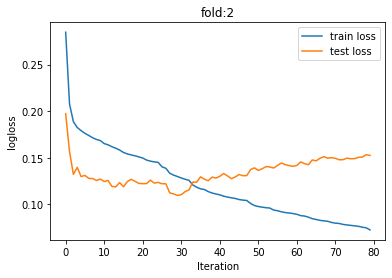

[I 2021-12-12 02:47:59,903] A new study created in memory with name: no-name-1c84368a-5cfa-4956-9c32-f21f1402a143
[I 2021-12-12 02:48:00,082] Trial 0 finished with value: 0.029952770153784128 and parameters: {'learning_rate': 0.429314947989316, 'num_leaves': 16, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.029952770153784128.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	Train's rmse: 0.165406	Test's rmse: 0.0299528
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:00,358] Trial 1 finished with value: 0.029614428286340252 and parameters: {'learning_rate': 0.8722404500826921, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 1 with value: 0.029614428286340252.


Early stopping, best iteration is:
[5]	Train's rmse: 0.171607	Test's rmse: 0.0296144
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[11]	Train's rmse: 0.176678	Test's rmse: 0.0287643


[I 2021-12-12 02:48:00,561] Trial 2 finished with value: 0.02876428010233214 and parameters: {'learning_rate': 0.5684340710238489, 'num_leaves': 29, 'tree_learner': 'data'}. Best is trial 2 with value: 0.02876428010233214.
[I 2021-12-12 02:48:00,752] Trial 3 finished with value: 0.025555489748740282 and parameters: {'learning_rate': 0.30983969675816997, 'num_leaves': 24, 'tree_learner': 'data'}. Best is trial 3 with value: 0.025555489748740282.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[13]	Train's rmse: 0.169864	Test's rmse: 0.0255555
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:01,078] Trial 4 finished with value: 0.02308010193029577 and parameters: {'learning_rate': 0.3210436499674221, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.02308010193029577.
[I 2021-12-12 02:48:01,181] Trial 5 finished with value: 0.028124254785509343 and parameters: {'learning_rate': 0.7726632946982475, 'num_leaves': 11, 'tree_learner': 'voting'}. Best is trial 4 with value: 0.02308010193029577.


Early stopping, best iteration is:
[15]	Train's rmse: 0.167664	Test's rmse: 0.0230801
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	Train's rmse: 0.154448	Test's rmse: 0.0281243
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:01,349] Trial 6 finished with value: 0.03158216202949542 and parameters: {'learning_rate': 0.8271004412902007, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 4 with value: 0.02308010193029577.


Early stopping, best iteration is:
[5]	Train's rmse: 0.180555	Test's rmse: 0.0315822
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:01,627] Trial 7 finished with value: 0.02349480440011624 and parameters: {'learning_rate': 0.3270854962822436, 'num_leaves': 38, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.02308010193029577.
[I 2021-12-12 02:48:01,740] Trial 8 finished with value: 0.034350848112565294 and parameters: {'learning_rate': 0.48067204853692314, 'num_leaves': 10, 'tree_learner': 'serial'}. Best is trial 4 with value: 0.02308010193029577.


Early stopping, best iteration is:
[18]	Train's rmse: 0.163147	Test's rmse: 0.0234948
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.159056	Test's rmse: 0.0343509
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:01,865] Trial 9 finished with value: 0.038657583985306304 and parameters: {'learning_rate': 0.7891931171905789, 'num_leaves': 11, 'tree_learner': 'data'}. Best is trial 4 with value: 0.02308010193029577.


Early stopping, best iteration is:
[4]	Train's rmse: 0.175756	Test's rmse: 0.0386576
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:02,367] Trial 10 finished with value: 0.02202701078245424 and parameters: {'learning_rate': 0.10222492260313151, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.02202701078245424.


Early stopping, best iteration is:
[44]	Train's rmse: 0.165844	Test's rmse: 0.022027
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:02,837] Trial 11 finished with value: 0.0209791926565409 and parameters: {'learning_rate': 0.12007459623160227, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 11 with value: 0.0209791926565409.


Early stopping, best iteration is:
[41]	Train's rmse: 0.167959	Test's rmse: 0.0209792
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:03,224] Trial 12 finished with value: 0.020347478912390672 and parameters: {'learning_rate': 0.11985744681182242, 'num_leaves': 38, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[41]	Train's rmse: 0.168201	Test's rmse: 0.0203475
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:03,604] Trial 13 finished with value: 0.02159131286654394 and parameters: {'learning_rate': 0.10130187133418772, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[41]	Train's rmse: 0.166491	Test's rmse: 0.0215913
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:03,911] Trial 14 finished with value: 0.02164883079682031 and parameters: {'learning_rate': 0.22487241308598493, 'num_leaves': 40, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[20]	Train's rmse: 0.165362	Test's rmse: 0.0216488
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:04,121] Trial 15 finished with value: 0.031090276239661603 and parameters: {'learning_rate': 0.6383498086754285, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[4]	Train's rmse: 0.18793	Test's rmse: 0.0310903
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:04,379] Trial 16 finished with value: 0.025877993703435177 and parameters: {'learning_rate': 0.9932150939192109, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[7]	Train's rmse: 0.177408	Test's rmse: 0.025878
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:04,711] Trial 17 finished with value: 0.021526109686689335 and parameters: {'learning_rate': 0.1997105113445974, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[20]	Train's rmse: 0.168771	Test's rmse: 0.0215261
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:05,003] Trial 18 finished with value: 0.02209621931157795 and parameters: {'learning_rate': 0.19768371969516613, 'num_leaves': 34, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[26]	Train's rmse: 0.16463	Test's rmse: 0.0220962
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:05,261] Trial 19 finished with value: 0.02490329522591947 and parameters: {'learning_rate': 0.4273999766565528, 'num_leaves': 41, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[9]	Train's rmse: 0.166723	Test's rmse: 0.0249033
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:05,538] Trial 20 finished with value: 0.03028628259702905 and parameters: {'learning_rate': 0.6355101908843871, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[4]	Train's rmse: 0.182237	Test's rmse: 0.0302863
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:05,894] Trial 21 finished with value: 0.02234506798845503 and parameters: {'learning_rate': 0.18399402751294303, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[25]	Train's rmse: 0.16494	Test's rmse: 0.0223451
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:06,202] Trial 22 finished with value: 0.02187935295188158 and parameters: {'learning_rate': 0.23603984386172389, 'num_leaves': 45, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[16]	Train's rmse: 0.169487	Test's rmse: 0.0218794
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:06,534] Trial 23 finished with value: 0.020889175621685643 and parameters: {'learning_rate': 0.14071333067293432, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[32]	Train's rmse: 0.166055	Test's rmse: 0.0208892
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:06,818] Trial 24 finished with value: 0.023073945945766103 and parameters: {'learning_rate': 0.14856373443253273, 'num_leaves': 28, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[30]	Train's rmse: 0.163171	Test's rmse: 0.0230739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:07,059] Trial 25 finished with value: 0.024019869489839925 and parameters: {'learning_rate': 0.26929059939515526, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.
[I 2021-12-12 02:48:07,239] Trial 26 finished with value: 0.02659483148222966 and parameters: {'learning_rate': 0.3818132082215371, 'num_leaves': 24, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[15]	Train's rmse: 0.171415	Test's rmse: 0.0240199
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[12]	Train's rmse: 0.164658	Test's rmse: 0.0265948
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:07,594] Trial 27 finished with value: 0.021959522402208533 and parameters: {'learning_rate': 0.13900652151521345, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[28]	Train's rmse: 0.169447	Test's rmse: 0.0219595
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	Train's rmse: 0.167362	Test's rmse: 0.0228596


[I 2021-12-12 02:48:07,803] Trial 28 finished with value: 0.02285963886376754 and parameters: {'learning_rate': 0.2746155074315103, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020347478912390672.
[I 2021-12-12 02:48:07,941] Trial 29 finished with value: 0.04815948809159693 and parameters: {'learning_rate': 0.5064291071584435, 'num_leaves': 6, 'tree_learner': 'feature'}. Best is trial 12 with value: 0.020347478912390672.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0735008	Test's rmse: 0.0481595
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:08,105] Trial 30 finished with value: 0.025971100609278597 and parameters: {'learning_rate': 0.3916189330481795, 'num_leaves': 17, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[13]	Train's rmse: 0.161018	Test's rmse: 0.0259711
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:08,489] Trial 31 finished with value: 0.022866684832679396 and parameters: {'learning_rate': 0.1672364556465446, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[30]	Train's rmse: 0.163892	Test's rmse: 0.0228667
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:08,934] Trial 32 finished with value: 0.021854404821541384 and parameters: {'learning_rate': 0.10606191663822671, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[40]	Train's rmse: 0.166492	Test's rmse: 0.0218544
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:09,205] Trial 33 finished with value: 0.022405433314488507 and parameters: {'learning_rate': 0.21297322142557443, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[19]	Train's rmse: 0.16894	Test's rmse: 0.0224054
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:09,440] Trial 34 finished with value: 0.022419387730844197 and parameters: {'learning_rate': 0.2607599246888774, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[17]	Train's rmse: 0.161522	Test's rmse: 0.0224194
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:09,841] Trial 35 finished with value: 0.021807849875468764 and parameters: {'learning_rate': 0.1519436156536992, 'num_leaves': 38, 'tree_learner': 'data'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[35]	Train's rmse: 0.163251	Test's rmse: 0.0218079
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:10,161] Trial 36 finished with value: 0.023183992394236436 and parameters: {'learning_rate': 0.3264897018148269, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[14]	Train's rmse: 0.168028	Test's rmse: 0.023184
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:10,479] Trial 37 finished with value: 0.024722773064575276 and parameters: {'learning_rate': 0.1890649870706077, 'num_leaves': 40, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[21]	Train's rmse: 0.16817	Test's rmse: 0.0247228
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[10]	Train's rmse: 0.168401	Test's rmse: 0.0250737

[I 2021-12-12 02:48:10,686] Trial 38 finished with value: 0.025073669063388978 and parameters: {'learning_rate': 0.3687075081861677, 'num_leaves': 26, 'tree_learner': 'data'}. Best is trial 12 with value: 0.020347478912390672.



Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:11,010] Trial 39 finished with value: 0.02515907306974154 and parameters: {'learning_rate': 0.3006234170296468, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[17]	Train's rmse: 0.155234	Test's rmse: 0.0251591
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:11,415] Trial 40 finished with value: 0.021561498665182803 and parameters: {'learning_rate': 0.1363545964210713, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[27]	Train's rmse: 0.170647	Test's rmse: 0.0215615
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:11,836] Trial 41 finished with value: 0.020462297635819707 and parameters: {'learning_rate': 0.1369092792490025, 'num_leaves': 49, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[31]	Train's rmse: 0.166296	Test's rmse: 0.0204623
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:12,213] Trial 42 finished with value: 0.02354451275962513 and parameters: {'learning_rate': 0.21934608796580524, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 12 with value: 0.020347478912390672.


Early stopping, best iteration is:
[21]	Train's rmse: 0.163944	Test's rmse: 0.0235445
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:12,639] Trial 43 finished with value: 0.020341091539106203 and parameters: {'learning_rate': 0.1353273445709139, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[34]	Train's rmse: 0.165547	Test's rmse: 0.0203411
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:13,114] Trial 44 finished with value: 0.021045341957143637 and parameters: {'learning_rate': 0.10711158765436303, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[41]	Train's rmse: 0.166996	Test's rmse: 0.0210453
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:13,505] Trial 45 finished with value: 0.021899835021313954 and parameters: {'learning_rate': 0.15832934360610715, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[30]	Train's rmse: 0.165827	Test's rmse: 0.0218998
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:13,720] Trial 46 finished with value: 0.021096252616758408 and parameters: {'learning_rate': 0.2566317645023092, 'num_leaves': 20, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[16]	Train's rmse: 0.168788	Test's rmse: 0.0210963
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:14,075] Trial 47 finished with value: 0.021258315165582884 and parameters: {'learning_rate': 0.10078101237307965, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166703	Test's rmse: 0.0212583
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:14,402] Trial 48 finished with value: 0.022102696537920404 and parameters: {'learning_rate': 0.3042412099970434, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[14]	Train's rmse: 0.165027	Test's rmse: 0.0221027
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:14,616] Trial 49 finished with value: 0.02659130344405662 and parameters: {'learning_rate': 0.7210649725506689, 'num_leaves': 37, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[5]	Train's rmse: 0.178032	Test's rmse: 0.0265913
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:14,879] Trial 50 finished with value: 0.030488240322907298 and parameters: {'learning_rate': 0.9224665663561828, 'num_leaves': 40, 'tree_learner': 'data'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[6]	Train's rmse: 0.16802	Test's rmse: 0.0304882
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:15,304] Trial 51 finished with value: 0.02168050141305735 and parameters: {'learning_rate': 0.1263230942473259, 'num_leaves': 47, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[31]	Train's rmse: 0.169057	Test's rmse: 0.0216805
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:15,701] Trial 52 finished with value: 0.022179992241087736 and parameters: {'learning_rate': 0.1829493512472078, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[23]	Train's rmse: 0.16908	Test's rmse: 0.02218
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:16,170] Trial 53 finished with value: 0.021628547482754282 and parameters: {'learning_rate': 0.13533362946528285, 'num_leaves': 50, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[33]	Train's rmse: 0.167164	Test's rmse: 0.0216285
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:16,495] Trial 54 finished with value: 0.022085930589867155 and parameters: {'learning_rate': 0.23132807933800975, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[18]	Train's rmse: 0.167098	Test's rmse: 0.0220859
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:16,941] Trial 55 finished with value: 0.021786213255971874 and parameters: {'learning_rate': 0.10164748813146648, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[41]	Train's rmse: 0.16726	Test's rmse: 0.0217862
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:17,310] Trial 56 finished with value: 0.02091583526503348 and parameters: {'learning_rate': 0.18046200922654632, 'num_leaves': 45, 'tree_learner': 'feature'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[24]	Train's rmse: 0.166484	Test's rmse: 0.0209158
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:17,613] Trial 57 finished with value: 0.022233674051916386 and parameters: {'learning_rate': 0.18445651798572085, 'num_leaves': 34, 'tree_learner': 'feature'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[25]	Train's rmse: 0.162197	Test's rmse: 0.0222337
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:17,942] Trial 58 finished with value: 0.022682963560094565 and parameters: {'learning_rate': 0.23784083634149733, 'num_leaves': 44, 'tree_learner': 'feature'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[19]	Train's rmse: 0.165565	Test's rmse: 0.022683
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:18,307] Trial 59 finished with value: 0.020558599098090664 and parameters: {'learning_rate': 0.1608745813981567, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[28]	Train's rmse: 0.166071	Test's rmse: 0.0205586
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:18,582] Trial 60 finished with value: 0.022999175197739207 and parameters: {'learning_rate': 0.34357313582728816, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 43 with value: 0.020341091539106203.


Early stopping, best iteration is:
[13]	Train's rmse: 0.166339	Test's rmse: 0.0229992
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:18,967] Trial 61 finished with value: 0.019302634218305696 and parameters: {'learning_rate': 0.1660903540939999, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[29]	Train's rmse: 0.16349	Test's rmse: 0.0193026
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:19,300] Trial 62 finished with value: 0.020954523339253336 and parameters: {'learning_rate': 0.16005666240606647, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[26]	Train's rmse: 0.167269	Test's rmse: 0.0209545
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:19,625] Trial 63 finished with value: 0.022534846504064857 and parameters: {'learning_rate': 0.20488638043132684, 'num_leaves': 42, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[19]	Train's rmse: 0.16636	Test's rmse: 0.0225348
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:19,964] Trial 64 finished with value: 0.02058134437281464 and parameters: {'learning_rate': 0.1621906602940542, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[27]	Train's rmse: 0.163834	Test's rmse: 0.0205813
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:20,220] Trial 65 finished with value: 0.022826524694145776 and parameters: {'learning_rate': 0.28663762121454955, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[16]	Train's rmse: 0.160976	Test's rmse: 0.0228265
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:20,472] Trial 66 finished with value: 0.0259407561950676 and parameters: {'learning_rate': 0.5741988812617024, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[11]	Train's rmse: 0.176914	Test's rmse: 0.0259408
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:20,822] Trial 67 finished with value: 0.023151149849568703 and parameters: {'learning_rate': 0.14334674883503126, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[35]	Train's rmse: 0.164258	Test's rmse: 0.0231512
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:21,129] Trial 68 finished with value: 0.021850621246921043 and parameters: {'learning_rate': 0.2456418165372156, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[16]	Train's rmse: 0.168174	Test's rmse: 0.0218506
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:21,378] Trial 69 finished with value: 0.02158281780961012 and parameters: {'learning_rate': 0.19952788384775305, 'num_leaves': 28, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[20]	Train's rmse: 0.170065	Test's rmse: 0.0215828
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:21,663] Trial 70 finished with value: 0.022128848513992418 and parameters: {'learning_rate': 0.17113211750696794, 'num_leaves': 34, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[24]	Train's rmse: 0.171368	Test's rmse: 0.0221289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:22,064] Trial 71 finished with value: 0.021057597483107517 and parameters: {'learning_rate': 0.13122476460985336, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[32]	Train's rmse: 0.169563	Test's rmse: 0.0210576
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:22,433] Trial 72 finished with value: 0.022028965447856815 and parameters: {'learning_rate': 0.1731503801494073, 'num_leaves': 45, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[24]	Train's rmse: 0.174455	Test's rmse: 0.022029
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:22,749] Trial 73 finished with value: 0.021065554589191987 and parameters: {'learning_rate': 0.22021799244424364, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[18]	Train's rmse: 0.169056	Test's rmse: 0.0210656
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:23,187] Trial 74 finished with value: 0.01977822192388731 and parameters: {'learning_rate': 0.13072612955679302, 'num_leaves': 46, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[35]	Train's rmse: 0.167006	Test's rmse: 0.0197782
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:23,602] Trial 75 finished with value: 0.020902732196138755 and parameters: {'learning_rate': 0.12944715446662275, 'num_leaves': 43, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[36]	Train's rmse: 0.165068	Test's rmse: 0.0209027
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:23,943] Trial 76 finished with value: 0.021947685061991472 and parameters: {'learning_rate': 0.15312463204619142, 'num_leaves': 37, 'tree_learner': 'data'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[25]	Train's rmse: 0.169202	Test's rmse: 0.0219477
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:24,156] Trial 77 finished with value: 0.025057921889995702 and parameters: {'learning_rate': 0.43573784118871783, 'num_leaves': 30, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[9]	Train's rmse: 0.169821	Test's rmse: 0.0250579
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:24,438] Trial 78 finished with value: 0.021936386358682492 and parameters: {'learning_rate': 0.12128341469560146, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[36]	Train's rmse: 0.164448	Test's rmse: 0.0219364
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:24,782] Trial 79 finished with value: 0.022308878685450586 and parameters: {'learning_rate': 0.20970403011506072, 'num_leaves': 46, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[22]	Train's rmse: 0.164872	Test's rmse: 0.0223089
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:25,199] Trial 80 finished with value: 0.020362786713392533 and parameters: {'learning_rate': 0.15929803459594746, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[26]	Train's rmse: 0.169916	Test's rmse: 0.0203628
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:25,607] Trial 81 finished with value: 0.020731526841327737 and parameters: {'learning_rate': 0.1529449726011, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[29]	Train's rmse: 0.169558	Test's rmse: 0.0207315
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:26,011] Trial 82 finished with value: 0.020658003599911517 and parameters: {'learning_rate': 0.15986062648638838, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[25]	Train's rmse: 0.168192	Test's rmse: 0.020658
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:26,380] Trial 83 finished with value: 0.021151880575292974 and parameters: {'learning_rate': 0.1948785758323075, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[20]	Train's rmse: 0.169796	Test's rmse: 0.0211519
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:26,710] Trial 84 finished with value: 0.022113559667762912 and parameters: {'learning_rate': 0.25184242714595517, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[16]	Train's rmse: 0.165444	Test's rmse: 0.0221136
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:27,200] Trial 85 finished with value: 0.021864117561868464 and parameters: {'learning_rate': 0.11626018667227213, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[42]	Train's rmse: 0.164515	Test's rmse: 0.0218641
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:27,533] Trial 86 finished with value: 0.02484881139455929 and parameters: {'learning_rate': 0.278517708258771, 'num_leaves': 46, 'tree_learner': 'data'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[14]	Train's rmse: 0.164375	Test's rmse: 0.0248488
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:27,937] Trial 87 finished with value: 0.020259108361812633 and parameters: {'learning_rate': 0.16400734430897285, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[27]	Train's rmse: 0.16578	Test's rmse: 0.0202591
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:28,290] Trial 88 finished with value: 0.021298944884646055 and parameters: {'learning_rate': 0.21401944492281944, 'num_leaves': 44, 'tree_learner': 'feature'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[18]	Train's rmse: 0.167902	Test's rmse: 0.0212989
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:28,673] Trial 89 finished with value: 0.022095603199913473 and parameters: {'learning_rate': 0.17275534163911832, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[24]	Train's rmse: 0.174496	Test's rmse: 0.0220956
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:29,150] Trial 90 finished with value: 0.02162577067261669 and parameters: {'learning_rate': 0.10145402649440297, 'num_leaves': 48, 'tree_learner': 'serial'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[39]	Train's rmse: 0.170764	Test's rmse: 0.0216258
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:29,552] Trial 91 finished with value: 0.020362476014793796 and parameters: {'learning_rate': 0.1606963913252556, 'num_leaves': 49, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[28]	Train's rmse: 0.166303	Test's rmse: 0.0203625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:29,963] Trial 92 finished with value: 0.021361258419707103 and parameters: {'learning_rate': 0.136767250237067, 'num_leaves': 47, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[30]	Train's rmse: 0.167786	Test's rmse: 0.0213613
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:30,408] Trial 93 finished with value: 0.021539775207009015 and parameters: {'learning_rate': 0.11914843496879932, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[37]	Train's rmse: 0.168899	Test's rmse: 0.0215398
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:30,753] Trial 94 finished with value: 0.0223738979378321 and parameters: {'learning_rate': 0.22976047180701625, 'num_leaves': 50, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[18]	Train's rmse: 0.167276	Test's rmse: 0.0223739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:31,130] Trial 95 finished with value: 0.022744297898060963 and parameters: {'learning_rate': 0.19206571543001488, 'num_leaves': 44, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[26]	Train's rmse: 0.16192	Test's rmse: 0.0227443
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:31,394] Trial 96 finished with value: 0.025639739181947122 and parameters: {'learning_rate': 0.7072351685428147, 'num_leaves': 48, 'tree_learner': 'voting'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[5]	Train's rmse: 0.178198	Test's rmse: 0.0256397
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:31,745] Trial 97 finished with value: 0.019870071967206655 and parameters: {'learning_rate': 0.15884427729228753, 'num_leaves': 42, 'tree_learner': 'serial'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[27]	Train's rmse: 0.169211	Test's rmse: 0.0198701
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:32,132] Trial 98 finished with value: 0.021317196750114568 and parameters: {'learning_rate': 0.1442074467535544, 'num_leaves': 43, 'tree_learner': 'serial'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[30]	Train's rmse: 0.168907	Test's rmse: 0.0213172
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:32,556] Trial 99 finished with value: 0.021336124117786005 and parameters: {'learning_rate': 0.11772118406667566, 'num_leaves': 45, 'tree_learner': 'serial'}. Best is trial 61 with value: 0.019302634218305696.


Early stopping, best iteration is:
[38]	Train's rmse: 0.169007	Test's rmse: 0.0213361
{'learning_rate': 0.1660903540939999, 'num_leaves': 43, 'tree_learner': 'feature'}
{'learning_rate': 0.1660903540939999, 'num_leaves': 43, 'tree_learner': 'feature', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	Train's rmse: 0.16349	Test's rmse: 0.0193026


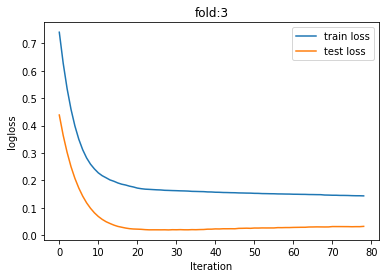

[I 2021-12-12 02:48:33,148] A new study created in memory with name: no-name-4cc28202-793d-4113-988e-e4c2824643f3


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:33,530] Trial 0 finished with value: 0.3617831112294689 and parameters: {'learning_rate': 0.9562655075239594, 'num_leaves': 28, 'tree_learner': 'data'}. Best is trial 0 with value: 0.3617831112294689.
[I 2021-12-12 02:48:33,662] Trial 1 finished with value: 0.36175127356288556 and parameters: {'learning_rate': 0.15432452155576007, 'num_leaves': 8, 'tree_learner': 'feature'}. Best is trial 1 with value: 0.36175127356288556.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0507452	Test's rmse: 0.361783
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[27]	Train's rmse: 0.15218	Test's rmse: 0.361751
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:33,807] Trial 2 finished with value: 0.3570272945675337 and parameters: {'learning_rate': 0.6404473288714547, 'num_leaves': 15, 'tree_learner': 'feature'}. Best is trial 2 with value: 0.3570272945675337.
[I 2021-12-12 02:48:33,972] Trial 3 finished with value: 0.3877913338536448 and parameters: {'learning_rate': 0.6190632003037014, 'num_leaves': 23, 'tree_learner': 'feature'}. Best is trial 2 with value: 0.3570272945675337.


Early stopping, best iteration is:
[6]	Train's rmse: 0.153228	Test's rmse: 0.357027
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.148997	Test's rmse: 0.387791
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:34,174] Trial 4 finished with value: 0.36262479010882365 and parameters: {'learning_rate': 0.4197347453856627, 'num_leaves': 24, 'tree_learner': 'serial'}. Best is trial 2 with value: 0.3570272945675337.


Early stopping, best iteration is:
[7]	Train's rmse: 0.156669	Test's rmse: 0.362625
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:34,485] Trial 5 finished with value: 0.3734982722394493 and parameters: {'learning_rate': 0.2640105472921903, 'num_leaves': 48, 'tree_learner': 'feature'}. Best is trial 2 with value: 0.3570272945675337.
[I 2021-12-12 02:48:34,639] Trial 6 finished with value: 0.37406401574489095 and parameters: {'learning_rate': 0.17752373266201216, 'num_leaves': 13, 'tree_learner': 'serial'}. Best is trial 2 with value: 0.3570272945675337.


Early stopping, best iteration is:
[12]	Train's rmse: 0.155739	Test's rmse: 0.373498
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[19]	Train's rmse: 0.155841	Test's rmse: 0.374064
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:34,785] Trial 7 finished with value: 0.3591332435407317 and parameters: {'learning_rate': 0.4375862983406612, 'num_leaves': 13, 'tree_learner': 'feature'}. Best is trial 2 with value: 0.3570272945675337.
[I 2021-12-12 02:48:34,863] Trial 8 finished with value: 0.3654402376473132 and parameters: {'learning_rate': 0.9486432595048115, 'num_leaves': 7, 'tree_learner': 'serial'}. Best is trial 2 with value: 0.3570272945675337.


Early stopping, best iteration is:
[10]	Train's rmse: 0.145615	Test's rmse: 0.359133
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	Train's rmse: 0.231301	Test's rmse: 0.36544
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:35,062] Trial 9 finished with value: 0.3668793152989114 and parameters: {'learning_rate': 0.38011277774738483, 'num_leaves': 25, 'tree_learner': 'feature'}. Best is trial 2 with value: 0.3570272945675337.


Early stopping, best iteration is:
[11]	Train's rmse: 0.146947	Test's rmse: 0.366879
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:35,311] Trial 10 finished with value: 0.34269793083034406 and parameters: {'learning_rate': 0.711751266844454, 'num_leaves': 38, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147292	Test's rmse: 0.342698
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:35,556] Trial 11 finished with value: 0.3765483309825238 and parameters: {'learning_rate': 0.6727569824879127, 'num_leaves': 40, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.16541	Test's rmse: 0.376548
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:35,779] Trial 12 finished with value: 0.3508924803375679 and parameters: {'learning_rate': 0.7716619171905967, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149282	Test's rmse: 0.350892
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:36,008] Trial 13 finished with value: 0.35428894005452616 and parameters: {'learning_rate': 0.809127702060005, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148335	Test's rmse: 0.354289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:36,259] Trial 14 finished with value: 0.35239519166103744 and parameters: {'learning_rate': 0.7861530337418778, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149287	Test's rmse: 0.352395
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:36,527] Trial 15 finished with value: 0.35425952773274405 and parameters: {'learning_rate': 0.8035678255313404, 'num_leaves': 46, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148383	Test's rmse: 0.35426
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:36,743] Trial 16 finished with value: 0.3473669246306906 and parameters: {'learning_rate': 0.5470093284440816, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[7]	Train's rmse: 0.148818	Test's rmse: 0.347367
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.154134	Test's rmse: 0.352291


[I 2021-12-12 02:48:36,936] Trial 17 finished with value: 0.3522911292821171 and parameters: {'learning_rate': 0.5321578012843453, 'num_leaves': 30, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:37,201] Trial 18 finished with value: 0.3530767271783778 and parameters: {'learning_rate': 0.5231577932006095, 'num_leaves': 41, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[6]	Train's rmse: 0.155412	Test's rmse: 0.353077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:37,457] Trial 19 finished with value: 0.369780463073397 and parameters: {'learning_rate': 0.3048076448668462, 'num_leaves': 32, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[10]	Train's rmse: 0.156208	Test's rmse: 0.36978
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:37,697] Trial 20 finished with value: 0.3603177864269253 and parameters: {'learning_rate': 0.7142685610876999, 'num_leaves': 42, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.163405	Test's rmse: 0.360318
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:38,069] Trial 21 finished with value: 0.36921576706371323 and parameters: {'learning_rate': 0.8768730303404589, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0545416	Test's rmse: 0.369216
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:38,304] Trial 22 finished with value: 0.35338278682794 and parameters: {'learning_rate': 0.5799334194782816, 'num_leaves': 33, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:38,450] Trial 23 finished with value: 0.3565441926698544 and parameters: {'learning_rate': 0.7127656008889657, 'num_leaves': 20, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.155699	Test's rmse: 0.353383
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.15288	Test's rmse: 0.356544
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:38,708] Trial 24 finished with value: 0.36140009792085803 and parameters: {'learning_rate': 0.4991428008713604, 'num_leaves': 39, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[6]	Train's rmse: 0.157141	Test's rmse: 0.3614
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:38,955] Trial 25 finished with value: 0.37099028047166477 and parameters: {'learning_rate': 0.7256299047434862, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:39,136] Trial 26 finished with value: 0.3687622222263776 and parameters: {'learning_rate': 0.8539543908676567, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.162987	Test's rmse: 0.37099
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	Train's rmse: 0.168292	Test's rmse: 0.368762


[I 2021-12-12 02:48:39,356] Trial 27 finished with value: 0.36191841512543255 and parameters: {'learning_rate': 0.5891451772896564, 'num_leaves': 28, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.152525	Test's rmse: 0.361918
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:39,718] Trial 28 finished with value: 0.3663181226839933 and parameters: {'learning_rate': 0.8949438835394761, 'num_leaves': 38, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[37]	Train's rmse: 0.0948364	Test's rmse: 0.366318
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:39,996] Trial 29 finished with value: 0.37132810583983994 and parameters: {'learning_rate': 0.7588521095701269, 'num_leaves': 50, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.161425	Test's rmse: 0.371328
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:40,252] Trial 30 finished with value: 0.37304917061325493 and parameters: {'learning_rate': 0.9755510884092473, 'num_leaves': 46, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[1]	Train's rmse: 0.184534	Test's rmse: 0.373049
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:40,477] Trial 31 finished with value: 0.3623203254423954 and parameters: {'learning_rate': 0.47797040493390786, 'num_leaves': 29, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[6]	Train's rmse: 0.156146	Test's rmse: 0.36232
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:40,697] Trial 32 finished with value: 0.3537352757096251 and parameters: {'learning_rate': 0.5495340935904263, 'num_leaves': 31, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[7]	Train's rmse: 0.150539	Test's rmse: 0.353735
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.1457	Test's rmse: 0.366556

[I 2021-12-12 02:48:40,912] Trial 33 finished with value: 0.3665564194735617 and parameters: {'learning_rate': 0.6416962383573831, 'num_leaves': 27, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:41,066] Trial 34 finished with value: 0.3724506777280806 and parameters: {'learning_rate': 0.6690201616413802, 'num_leaves': 20, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.



Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.146276	Test's rmse: 0.372451
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.144239	Test's rmse: 0.367786


[I 2021-12-12 02:48:41,311] Trial 35 finished with value: 0.3677855641913875 and parameters: {'learning_rate': 0.5979202374718269, 'num_leaves': 34, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:41,582] Trial 36 finished with value: 0.3651847281930371 and parameters: {'learning_rate': 0.3813590546918915, 'num_leaves': 37, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:41,748] Trial 37 finished with value: 0.3596680506579586 and parameters: {'learning_rate': 0.44742473824374607, 'num_leaves': 21, 'tree_learner': 'data'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[11]	Train's rmse: 0.146141	Test's rmse: 0.365185
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.160362	Test's rmse: 0.359668
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:41,962] Trial 38 finished with value: 0.3543342568509317 and parameters: {'learning_rate': 0.5576779528733936, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:42,126] Trial 39 finished with value: 0.3440849796234321 and parameters: {'learning_rate': 0.6774433010385592, 'num_leaves': 26, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[7]	Train's rmse: 0.151302	Test's rmse: 0.354334
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.151026	Test's rmse: 0.344085
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:42,403] Trial 40 finished with value: 0.3759150928213537 and parameters: {'learning_rate': 0.6411026966862383, 'num_leaves': 17, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0712066	Test's rmse: 0.375915
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:42,613] Trial 41 finished with value: 0.37278524430375226 and parameters: {'learning_rate': 0.6820700898659774, 'num_leaves': 27, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:42,790] Trial 42 finished with value: 0.3535570283044889 and parameters: {'learning_rate': 0.7513297957608456, 'num_leaves': 25, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[8]	Train's rmse: 0.142987	Test's rmse: 0.372785
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.152806	Test's rmse: 0.353557
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:43,049] Trial 43 finished with value: 0.3548277414428157 and parameters: {'learning_rate': 0.835875221585087, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:43,219] Trial 44 finished with value: 0.3887725033071944 and parameters: {'learning_rate': 0.6243066779097626, 'num_leaves': 23, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147484	Test's rmse: 0.354828
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.148791	Test's rmse: 0.388773
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:43,506] Trial 45 finished with value: 0.37439371567103025 and parameters: {'learning_rate': 0.12474679492311369, 'num_leaves': 26, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[26]	Train's rmse: 0.158331	Test's rmse: 0.374394
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:43,859] Trial 46 finished with value: 0.369598880358217 and parameters: {'learning_rate': 0.9122168028699287, 'num_leaves': 29, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0583068	Test's rmse: 0.369599
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:44,092] Trial 47 finished with value: 0.368822026390045 and parameters: {'learning_rate': 0.3924308750207105, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:44,202] Trial 48 finished with value: 0.3577932830527946 and parameters: {'learning_rate': 0.3286820903424917, 'num_leaves': 9, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[6]	Train's rmse: 0.166335	Test's rmse: 0.368822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	Train's rmse: 0.158052	Test's rmse: 0.357793
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:44,497] Trial 49 finished with value: 0.36138216351602587 and parameters: {'learning_rate': 0.517779972270979, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[6]	Train's rmse: 0.154575	Test's rmse: 0.361382
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:44,740] Trial 50 finished with value: 0.35091280893218024 and parameters: {'learning_rate': 0.7677108589457015, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.150043	Test's rmse: 0.350913
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:44,982] Trial 51 finished with value: 0.3515093223479321 and parameters: {'learning_rate': 0.7720686918073171, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149488	Test's rmse: 0.351509
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:45,250] Trial 52 finished with value: 0.35205495993205416 and parameters: {'learning_rate': 0.7797799102992643, 'num_leaves': 45, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149137	Test's rmse: 0.352055
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:45,506] Trial 53 finished with value: 0.3549112010319924 and parameters: {'learning_rate': 0.815322345416748, 'num_leaves': 40, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147934	Test's rmse: 0.354911
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.162549	Test's rmse: 0.370964

[I 2021-12-12 02:48:45,719] Trial 54 finished with value: 0.37096424293114666 and parameters: {'learning_rate': 0.73328223047057, 'num_leaves': 37, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.



Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:45,959] Trial 55 finished with value: 0.37578366272596136 and parameters: {'learning_rate': 0.6862602533930952, 'num_leaves': 39, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.164494	Test's rmse: 0.375784
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:46,212] Trial 56 finished with value: 0.35088307184133916 and parameters: {'learning_rate': 0.7728987188006905, 'num_leaves': 44, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149562	Test's rmse: 0.350883
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:46,478] Trial 57 finished with value: 0.36874217434164785 and parameters: {'learning_rate': 0.8531529628090652, 'num_leaves': 45, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[2]	Train's rmse: 0.168052	Test's rmse: 0.368742
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:46,748] Trial 58 finished with value: 0.3609548187738287 and parameters: {'learning_rate': 0.7049900151237547, 'num_leaves': 48, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.163967	Test's rmse: 0.360955
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:46,967] Trial 59 finished with value: 0.35361674334021065 and parameters: {'learning_rate': 0.8101752653398481, 'num_leaves': 35, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148161	Test's rmse: 0.353617
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:47,430] Trial 60 finished with value: 0.3546117395094841 and parameters: {'learning_rate': 0.932917606502509, 'num_leaves': 43, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0569042	Test's rmse: 0.354612
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:47,688] Trial 61 finished with value: 0.3712278494651166 and parameters: {'learning_rate': 0.7535812338474152, 'num_leaves': 41, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[3]	Train's rmse: 0.161768	Test's rmse: 0.371228
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:47,917] Trial 62 finished with value: 0.350767942413968 and parameters: {'learning_rate': 0.7713399891588187, 'num_leaves': 37, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149622	Test's rmse: 0.350768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:48,150] Trial 63 finished with value: 0.3520940857329589 and parameters: {'learning_rate': 0.7892884158486955, 'num_leaves': 38, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148358	Test's rmse: 0.352094
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:48,368] Trial 64 finished with value: 0.34952584016937976 and parameters: {'learning_rate': 0.6641879716616129, 'num_leaves': 33, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[4]	Train's rmse: 0.157486	Test's rmse: 0.349526
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:48,601] Trial 65 finished with value: 0.3680462615215221 and parameters: {'learning_rate': 0.6183729975375346, 'num_leaves': 32, 'tree_learner': 'feature'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[8]	Train's rmse: 0.142315	Test's rmse: 0.368046
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:48,818] Trial 66 finished with value: 0.3495259033135852 and parameters: {'learning_rate': 0.6640918219929818, 'num_leaves': 33, 'tree_learner': 'voting'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[4]	Train's rmse: 0.157491	Test's rmse: 0.349526
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:49,040] Trial 67 finished with value: 0.349564939262057 and parameters: {'learning_rate': 0.6610091535272105, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[4]	Train's rmse: 0.157676	Test's rmse: 0.349565
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.15771	Test's rmse: 0.349538


[I 2021-12-12 02:48:49,243] Trial 68 finished with value: 0.3495376389384967 and parameters: {'learning_rate': 0.6600318696916225, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:49,442] Trial 69 finished with value: 0.34953670150046434 and parameters: {'learning_rate': 0.6603444354997972, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.157693	Test's rmse: 0.349537
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:49,712] Trial 70 finished with value: 0.354436635977974 and parameters: {'learning_rate': 0.5690295767202603, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[7]	Train's rmse: 0.150528	Test's rmse: 0.354437
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:49,928] Trial 71 finished with value: 0.372900409734998 and parameters: {'learning_rate': 0.6521446381833957, 'num_leaves': 32, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[4]	Train's rmse: 0.159278	Test's rmse: 0.3729
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	Train's rmse: 0.143425	Test's rmse: 0.368828


[I 2021-12-12 02:48:50,136] Trial 72 finished with value: 0.3688276270575254 and parameters: {'learning_rate': 0.6104436255094065, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.
[I 2021-12-12 02:48:50,321] Trial 73 finished with value: 0.349673351392847 and parameters: {'learning_rate': 0.6612612777266712, 'num_leaves': 31, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	Train's rmse: 0.157715	Test's rmse: 0.349673
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:50,531] Trial 74 finished with value: 0.34431484880256447 and parameters: {'learning_rate': 0.6980408283147393, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.15006	Test's rmse: 0.344315
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:50,762] Trial 75 finished with value: 0.34436014542860355 and parameters: {'learning_rate': 0.6993890304209084, 'num_leaves': 33, 'tree_learner': 'serial'}. Best is trial 10 with value: 0.34269793083034406.


Early stopping, best iteration is:
[5]	Train's rmse: 0.149988	Test's rmse: 0.34436
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.147679	Test's rmse: 0.342564


[I 2021-12-12 02:48:50,956] Trial 76 finished with value: 0.3425635734719858 and parameters: {'learning_rate': 0.7165735491210624, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.
[I 2021-12-12 02:48:51,158] Trial 77 finished with value: 0.371392672856664 and parameters: {'learning_rate': 0.7259083514972743, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.163393	Test's rmse: 0.371393
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:51,458] Trial 78 finished with value: 0.3633740038787005 and parameters: {'learning_rate': 0.7007161028512259, 'num_leaves': 23, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0625556	Test's rmse: 0.363374
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:51,674] Trial 79 finished with value: 0.3619255308747855 and parameters: {'learning_rate': 0.5894645953811688, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.
[I 2021-12-12 02:48:51,863] Trial 80 finished with value: 0.38782459194587804 and parameters: {'learning_rate': 0.6343024610530986, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Early stopping, best iteration is:
[6]	Train's rmse: 0.152505	Test's rmse: 0.361926
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.148665	Test's rmse: 0.387825


[I 2021-12-12 02:48:52,074] Trial 81 finished with value: 0.3754668235437849 and parameters: {'learning_rate': 0.6918619807567167, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.16416	Test's rmse: 0.375467


[I 2021-12-12 02:48:52,298] Trial 82 finished with value: 0.35989383742088626 and parameters: {'learning_rate': 0.7137194108239081, 'num_leaves': 36, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.163039	Test's rmse: 0.359894


[I 2021-12-12 02:48:52,495] Trial 83 finished with value: 0.3713603750977193 and parameters: {'learning_rate': 0.7391598212533973, 'num_leaves': 30, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	Train's rmse: 0.162588	Test's rmse: 0.37136
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:52,735] Trial 84 finished with value: 0.3759451314694493 and parameters: {'learning_rate': 0.684584266229827, 'num_leaves': 34, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Early stopping, best iteration is:
[3]	Train's rmse: 0.164709	Test's rmse: 0.375945
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:52,960] Trial 85 finished with value: 0.3670171515147837 and parameters: {'learning_rate': 0.48690675835971364, 'num_leaves': 33, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Early stopping, best iteration is:
[5]	Train's rmse: 0.163071	Test's rmse: 0.367017
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.150752	Test's rmse: 0.363641


[I 2021-12-12 02:48:53,153] Trial 86 finished with value: 0.3636410083263841 and parameters: {'learning_rate': 0.6053641860019372, 'num_leaves': 28, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.
[I 2021-12-12 02:48:53,363] Trial 87 finished with value: 0.3536688970604846 and parameters: {'learning_rate': 0.5485605223878314, 'num_leaves': 31, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	Train's rmse: 0.150613	Test's rmse: 0.353669


[I 2021-12-12 02:48:53,585] Trial 88 finished with value: 0.3651096617430228 and parameters: {'learning_rate': 0.6355176147731578, 'num_leaves': 35, 'tree_learner': 'serial'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.150807	Test's rmse: 0.36511


[I 2021-12-12 02:48:53,791] Trial 89 finished with value: 0.34944057258358246 and parameters: {'learning_rate': 0.7395509683730354, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.153743	Test's rmse: 0.349441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:54,001] Trial 90 finished with value: 0.3816779474686216 and parameters: {'learning_rate': 0.22036424689780665, 'num_leaves': 24, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.
[I 2021-12-12 02:48:54,169] Trial 91 finished with value: 0.3526747370518469 and parameters: {'learning_rate': 0.7340339328313205, 'num_leaves': 25, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Early stopping, best iteration is:
[15]	Train's rmse: 0.155255	Test's rmse: 0.381678
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.153855	Test's rmse: 0.352675


[I 2021-12-12 02:48:54,377] Trial 92 finished with value: 0.36695105775654724 and parameters: {'learning_rate': 0.6728802924520829, 'num_leaves': 27, 'tree_learner': 'voting'}. Best is trial 76 with value: 0.3425635734719858.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	Train's rmse: 0.150493	Test's rmse: 0.366951
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:54,586] Trial 93 finished with value: 0.3418110949554309 and parameters: {'learning_rate': 0.7051826650408346, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148372	Test's rmse: 0.341811
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:54,815] Trial 94 finished with value: 0.3754652658809983 and parameters: {'learning_rate': 0.6928366094726072, 'num_leaves': 29, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.
[I 2021-12-12 02:48:54,990] Trial 95 finished with value: 0.3529084599587475 and parameters: {'learning_rate': 0.7462857463456207, 'num_leaves': 22, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.


Early stopping, best iteration is:
[3]	Train's rmse: 0.164229	Test's rmse: 0.375465
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.152938	Test's rmse: 0.352908
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:55,339] Trial 96 finished with value: 0.35518166566391257 and parameters: {'learning_rate': 0.7205366939115455, 'num_leaves': 26, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0578939	Test's rmse: 0.355182
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:55,562] Trial 97 finished with value: 0.3524309074522939 and parameters: {'learning_rate': 0.7980743826780576, 'num_leaves': 36, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147978	Test's rmse: 0.352431
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:55,800] Trial 98 finished with value: 0.34237370029540787 and parameters: {'learning_rate': 0.7058575930473152, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 93 with value: 0.3418110949554309.


Early stopping, best iteration is:
[5]	Train's rmse: 0.147966	Test's rmse: 0.342374
Training until validation scores don't improve for 50 rounds.


[I 2021-12-12 02:48:56,022] Trial 99 finished with value: 0.341706009443522 and parameters: {'learning_rate': 0.7027358562136878, 'num_leaves': 30, 'tree_learner': 'voting'}. Best is trial 99 with value: 0.341706009443522.


Early stopping, best iteration is:
[5]	Train's rmse: 0.148439	Test's rmse: 0.341706
{'learning_rate': 0.7027358562136878, 'num_leaves': 30, 'tree_learner': 'voting'}
{'learning_rate': 0.7027358562136878, 'num_leaves': 30, 'tree_learner': 'voting', 'objective': 'regression', 'metric': 'rmse', 'task': 'train', 'seed': 42}
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	Train's rmse: 0.148439	Test's rmse: 0.341706


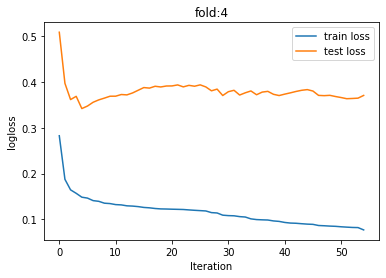

RMSE: [0.31119078793952454, 0.10406013281424457, 0.1094769892109066, 0.019302634218305696, 0.341706009443522]
RMSE: 0.17714731072530068


In [ ]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

cv_result_opt2 = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物
    
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)

    best_params = study.best_params

    add_params = {
        'objective':'regression', 
        'metric': 'rmse', 
        'task': 'train', 
        'seed': SEED
        }

    best_params.update(add_params)

    print(best_params)

    model = lgb.train(
                    params=best_params,               # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt2.append(rmse)

print("RMSE:", cv_result_opt2)
print("RMSE:", np.mean(cv_result_opt2))

In [ ]:
print("RMSE:", round(np.mean(cv_result), 3))
print("Optuna によるハイパラ調整 1 RMSE:", round(np.mean(cv_result_opt), 3))
print("Optuna によるハイパラ調整 2 RMSE:", round(np.mean(cv_result_opt2), 3))

RMSE: 0.199
Optuna によるハイパラ調整 1 RMSE: 0.182
Optuna によるハイパラ調整 2 RMSE: 0.177
